In [ ]:
print("📦 Installing required packages...")
print("="*70)

# Install segmentation models pytorch and dependencies
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q timm

print("\n✅ All packages installed successfully!")
print("="*70)

# Verify installation
try:
    import segmentation_models_pytorch as smp
    import albumentations as A
    import timm
    print("✅ segmentation-models-pytorch imported successfully")
    print("✅ albumentations imported successfully")
    print("✅ timm imported successfully")
except Exception as e:
    print(f"❌ Error: {e}")


📦 Installing required packages...

✅ All packages installed successfully!
✅ segmentation-models-pytorch imported successfully
✅ albumentations imported successfully
✅ timm imported successfully


In [ ]:
import os
import shutil

# Remove any existing extraction
!rm -rf train val test

# Unzip
print("📦 Extracting preprocessed_dataset.zip...")
!unzip -o -q preprocessed_dataset.zip

# Check what was extracted
print("\n📁 Current structure:")
!ls -la

# The zip creates: preprocessed_dataset/train/, preprocessed_dataset/val/, etc.
# We need to move them to root level

if os.path.exists('preprocessed_dataset'):
    print("\n🔄 Moving folders from preprocessed_dataset/ to root...")

    # Move train, val, test to root
    if os.path.exists('preprocessed_dataset/train'):
        shutil.move('preprocessed_dataset/train', 'train')
        print("✅ Moved train/")

    if os.path.exists('preprocessed_dataset/val'):
        shutil.move('preprocessed_dataset/val', 'val')
        print("✅ Moved val/")

    if os.path.exists('preprocessed_dataset/test'):
        shutil.move('preprocessed_dataset/test', 'test')
        print("✅ Moved test/")

    # Remove empty preprocessed_dataset folder
    shutil.rmtree('preprocessed_dataset', ignore_errors=True)
    print("✅ Cleaned up")

# Verify final structure
print("\n📊 Dataset Summary:")
train_imgs = len(os.listdir('train/images'))
train_masks = len(os.listdir('train/masks'))
val_imgs = len(os.listdir('val/images'))
val_masks = len(os.listdir('val/masks'))
test_imgs = len(os.listdir('test/images'))
test_masks = len(os.listdir('test/masks'))

print(f"   Train: {train_imgs} images, {train_masks} masks")
print(f"   Val:   {val_imgs} images, {val_masks} masks")
print(f"   Test:  {test_imgs} images, {test_masks} masks")

# Show sample files
print(f"\n🔍 Sample train images:")
!ls train/images | head -3

print(f"\n🔍 Sample train masks:")
!ls train/masks | head -3

if train_imgs == 811 and val_imgs == 203 and test_imgs == 254:
    print("\n✅ Dataset is PERFECT and ready for training!")
else:
    print(f"\n⚠️ Warning: File counts don't match expected values")
    print(f"   Expected: 811 train, 203 val, 254 test")


📦 Extracting preprocessed_dataset.zip...

📁 Current structure:
total 121200
drwxr-xr-x 1 root root      4096 Dec 18 16:03 .
drwxr-xr-x 1 root root      4096 Dec 18 15:50 ..
drwxr-xr-x 4 root root      4096 Dec  9 14:41 .config
drwx------ 5 root root      4096 Dec 18 16:00 drive
drwxr-xr-x 2 root root      4096 Dec 18 15:59 .ipynb_checkpoints
drwxrwxrwx 5 root root      4096 Dec  5 12:05 preprocessed_dataset
-rw-r--r-- 1 root root 124068777 Dec 18 16:02 preprocessed_dataset.zip
drwxr-xr-x 1 root root      4096 Dec 18 15:59 sample_data

🔄 Moving folders from preprocessed_dataset/ to root...
✅ Moved train/
✅ Moved val/
✅ Moved test/
✅ Cleaned up

📊 Dataset Summary:
   Train: 811 images, 811 masks
   Val:   203 images, 203 masks
   Test:  254 images, 254 masks

🔍 Sample train images:
Oil (1000).png
Oil (1001).png
Oil (1002).png

🔍 Sample train masks:
Oil (1000).png
Oil (1001).png
Oil (1002).png

✅ Dataset is PERFECT and ready for training!


In [ ]:
!pip install -q albumentations
print("✅ Albumentations installed")


✅ Albumentations installed


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
import cv2

class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.size = size

        # Get paired files
        img_files = set(os.listdir(img_dir))
        mask_files = set(os.listdir(mask_dir))
        img_stems = {os.path.splitext(f)[0] for f in img_files}
        mask_stems = {os.path.splitext(f)[0] for f in mask_files}
        paired_stems = img_stems.intersection(mask_stems)

        self.pairs = []
        for stem in paired_stems:
            img_file = [f for f in img_files if os.path.splitext(f)[0]==stem][0]
            mask_file = [f for f in mask_files if os.path.splitext(f)[0]==stem][0]
            self.pairs.append((img_file, mask_file))

        print(f"✅ Loaded {len(self.pairs)} pairs from {img_dir}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]

        # Load image
        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(os.path.join(self.mask_dir, mask_name))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Resize
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # Convert mask to class indices
        mask = self.rgb_to_class(mask)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # Normalize image
        img = img.astype(np.float32) / 255.0

        # Convert to tensor
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return img, mask

    def rgb_to_class(self, mask):
        """Convert RGB to class indices with tolerance"""
        h, w = mask.shape[:2]
        class_mask = np.zeros((h, w), dtype=np.uint8)

        colors = {
            0: np.array([0, 0, 0]),
            1: np.array([255, 0, 124]),
            2: np.array([255, 204, 51]),
            3: np.array([51, 221, 255])
        }

        for class_id, color in colors.items():
            diff = np.abs(mask.astype(np.float32) - color.astype(np.float32))
            matches = np.all(diff < 30, axis=-1)
            class_mask[matches] = class_id

        return class_mask


def get_train_transform(size=256):
    """AGGRESSIVE augmentation for maximum generalization"""
    return A.Compose([
        # Geometric transforms
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.3, rotate_limit=45, p=0.7),

        # Spatial transforms
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=6, p=1),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=1),
            A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
        ], p=0.5),

        # Color/Intensity transforms (critical for SAR images)
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
            A.RandomGamma(gamma_limit=(70, 130), p=1),
        ], p=0.7),

        # Noise augmentation
        A.OneOf([
            A.GaussNoise(p=1),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=1),
        ], p=0.4),

        # Blur augmentation
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=1),
            A.GaussianBlur(blur_limit=5, p=1),
        ], p=0.3),

        # Dropout for regularization
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32,
                        min_holes=1, min_height=8, min_width=8,
                        fill_value=0, p=0.3),
    ])

def get_val_transform(size=256):
    """No augmentation for validation"""
    return None

print("✅ Enhanced dataset with aggressive augmentation ready!")

✅ Enhanced dataset with aggressive augmentation ready!


In [ ]:
import segmentation_models_pytorch as smp

def get_model(encoder='resnet34', num_classes=4):
    """
    Use pre-trained encoder for MUCH better performance
    encoder options: resnet34, resnet50, efficientnet-b0, mobilenet_v2
    """
    model = smp.Unet(
        encoder_name=encoder,
        encoder_weights='imagenet',  # Use ImageNet pre-trained weights!
        in_channels=3,
        classes=num_classes,
        activation=None
    )
    return model

# Create model
model = get_model(encoder='resnet34', num_classes=4)
print(f"✅ Pre-trained U-Net (ResNet34 encoder) loaded!")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ Pre-trained U-Net (ResNet34 encoder) loaded!
📊 Total parameters: 24.44M


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=class_weights)

    def dice_loss(self, pred, target, smooth=1.0):
        pred = F.softmax(pred, dim=1)
        num_classes = pred.shape[1]
        dice = 0.0

        for c in range(num_classes):
            pred_c = pred[:, c]
            target_c = (target == c).float()
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()
            dice += (2. * intersection + smooth) / (union + smooth)

        return 1 - dice / num_classes

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice_loss(pred, target)
        return 0.5 * ce_loss + 0.5 * dice_loss

print("✅ Advanced loss function ready!")


✅ Advanced loss function ready!


In [ ]:
import numpy as np

def pixel_accuracy(pred, target):
    """Overall pixel accuracy"""
    pred = torch.argmax(pred, dim=1)
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total


def iou_score(pred, target, num_classes=4):
    """Mean IoU (Intersection over Union)"""
    pred = torch.argmax(pred, dim=1)
    ious = []

    for c in range(num_classes):
        pred_c = (pred == c)
        target_c = (target == c)

        intersection = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()

        if union > 0:
            ious.append(intersection / union)

    return np.mean(ious) if ious else 0.0


def dice_coefficient(pred, target, num_classes=4):
    """Mean Dice coefficient"""
    pred = torch.argmax(pred, dim=1)
    dices = []

    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum().item()
        dice = (2 * intersection) / (pred_c.sum().item() + target_c.sum().item() + 1e-8)
        dices.append(dice)

    return np.mean(dices)


def precision_recall(pred, target, num_classes=4):
    """Mean precision and recall"""
    pred = torch.argmax(pred, dim=1)
    precisions = []
    recalls = []

    for c in range(num_classes):
        pred_c = (pred == c)
        target_c = (target == c)

        tp = (pred_c & target_c).sum().item()
        fp = (pred_c & ~target_c).sum().item()
        fn = (~pred_c & target_c).sum().item()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)


print("✅ All metrics ready!")


✅ All metrics ready!


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from tqdm import tqdm

# ============ CONFIGURATION ============
DEVICE = torch.device('cuda')
BATCH_SIZE = 16
IMG_SIZE = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100  # Run full epochs for maximum performance
NUM_CLASSES = 4

print(f"🎯 Maximum Performance Training Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Strategy: Train to absolute maximum (no early stopping)")

# ============ DATASETS ============
train_dataset = OilSpillDataset('train/images', 'train/masks',
                                get_train_transform(IMG_SIZE), size=IMG_SIZE)
val_dataset = OilSpillDataset('val/images', 'val/masks',
                              get_val_transform(IMG_SIZE), size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"\n📊 Dataset Summary:")
print(f"   Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"   Val: {len(val_dataset)} samples ({len(val_loader)} batches)")

# ============ MODEL & OPTIMIZER ============
model = model.to(DEVICE)

# Class weights for imbalanced data
class_weights = torch.tensor([1.0, 5.0, 2.0, 1.0]).to(DEVICE)
criterion = CombinedLoss(class_weights=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Cosine annealing for smooth learning rate decay
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-7
)

scaler = GradScaler('cuda')

# ============ TRAINING FUNCTIONS ============
def train_epoch(model, loader, criterion, optimizer, scaler, scheduler):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(loader, desc="🔄 Training", leave=False)
    for images, masks in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()

        # Gradient clipping for stability
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        running_acc += pixel_accuracy(outputs, masks)

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return running_loss / len(loader), running_acc / len(loader)


def validate(model, loader, criterion):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc="📊 Validating", leave=False)
        for images, masks in pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_acc += pixel_accuracy(outputs, masks)
            running_iou += iou_score(outputs, masks, NUM_CLASSES)
            running_dice += dice_coefficient(outputs, masks, NUM_CLASSES)

            prec, rec = precision_recall(outputs, masks, NUM_CLASSES)
            running_prec += prec
            running_rec += rec

    n = len(loader)
    return {
        'loss': running_loss / n,
        'acc': running_acc / n,
        'iou': running_iou / n,
        'dice': running_dice / n,
        'precision': running_prec / n,
        'recall': running_rec / n
    }


# ============ TRAINING LOOP (NO EARLY STOPPING) ============
best_iou = 0.0
best_acc = 0.0
best_epoch = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_iou': [],
    'val_dice': [],
    'val_precision': [],
    'val_recall': [],
    'learning_rates': []
}

print("\n" + "="*80)
print("🚀 STARTING TRAINING - NO LIMITS, MAXIMUM PERFORMANCE MODE")
print("="*80 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*80}")
    print(f"📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*80}")

    # TRAIN FIRST
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, scheduler)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"📈 Training Results:")
    print(f"   Loss: {train_loss:.4f}")
    print(f"   Accuracy: {train_acc*100:.2f}%")
    print(f"   Learning Rate: {current_lr:.7f}")

    # THEN VALIDATE
    val_metrics = validate(model, val_loader, criterion)

    print(f"\n📊 Validation Results:")
    print(f"   Loss: {val_metrics['loss']:.4f}")
    print(f"   Accuracy: {val_metrics['acc']*100:.2f}%")
    print(f"   IoU: {val_metrics['iou']*100:.2f}%")
    print(f"   Dice: {val_metrics['dice']:.4f}")
    print(f"   Precision: {val_metrics['precision']:.4f}")
    print(f"   Recall: {val_metrics['recall']:.4f}")

    # Generalization gap analysis
    loss_gap = train_loss - val_metrics['loss']
    acc_gap = train_acc - val_metrics['acc']

    print(f"\n🔍 Generalization Analysis:")
    print(f"   Loss Gap (Train-Val): {loss_gap:+.4f}", end="")
    if abs(loss_gap) < 0.05:
        print(" ✅ Excellent!")
    elif loss_gap > 0.15:
        print(" ⚠️ Overfitting detected")
    else:
        print(" ✅ Good")

    print(f"   Acc Gap (Train-Val): {acc_gap*100:+.2f}%", end="")
    if abs(acc_gap) < 0.03:
        print(" ✅ Excellent!")
    elif acc_gap > 0.10:
        print(" ⚠️ Overfitting detected")
    else:
        print(" ✅ Good")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['acc'])
    history['val_iou'].append(val_metrics['iou'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['learning_rates'].append(current_lr)

    # Save best model (based on IoU)
    if val_metrics['iou'] > best_iou:
        best_iou = val_metrics['iou']
        best_acc = val_metrics['acc']
        best_epoch = epoch + 1

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_metrics['loss'],
            'val_iou': val_metrics['iou'],
            'val_acc': val_metrics['acc'],
            'val_dice': val_metrics['dice'],
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'train_loss': train_loss,
            'train_acc': train_acc,
            'history': history
        }, 'best_model.pth')

        print(f"\n   🏆 NEW BEST MODEL SAVED!")
        print(f"   Best IoU: {best_iou*100:.2f}%")
        print(f"   Best Accuracy: {best_acc*100:.2f}%")

    # Save checkpoint every 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'checkpoint_epoch_{epoch+1}.pth')
        print(f"   💾 Checkpoint saved at epoch {epoch+1}")

# Final summary
print(f"\n{'='*80}")
print(f"🏆 TRAINING COMPLETED - MAXIMUM PERFORMANCE ACHIEVED!")
print(f"{'='*80}")
print(f"\n📊 Best Model Performance (Epoch {best_epoch}):")
print(f"   Validation IoU: {best_iou*100:.2f}%")
print(f"   Validation Accuracy: {best_acc*100:.2f}%")

print(f"\n📊 All-Time Maximum Metrics:")
print(f"   Max Val Accuracy: {max(history['val_acc'])*100:.2f}% (Epoch {history['val_acc'].index(max(history['val_acc']))+1})")
print(f"   Max Val IoU: {max(history['val_iou'])*100:.2f}% (Epoch {history['val_iou'].index(max(history['val_iou']))+1})")
print(f"   Max Val Dice: {max(history['val_dice']):.4f} (Epoch {history['val_dice'].index(max(history['val_dice']))+1})")
print(f"   Min Val Loss: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")

print(f"\n📊 Final Epoch Performance:")
print(f"   Val Accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"   Val IoU: {history['val_iou'][-1]*100:.2f}%")
print(f"   Val Dice: {history['val_dice'][-1]:.4f}")

print(f"\n🎯 Training Statistics:")
print(f"   Total Epochs: {epoch+1}")
print(f"   Best Model at Epoch: {best_epoch}")
print(f"   Final Learning Rate: {history['learning_rates'][-1]:.7f}")
print(f"{'='*80}")


🎯 Maximum Performance Training Configuration:
   Device: cuda
   Batch Size: 16
   Image Size: 256x256
   Learning Rate: 0.0001
   Epochs: 100
   Strategy: Train to absolute maximum (no early stopping)


/tmp/ipython-input-127637400.py:100: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
/tmp/ipython-input-127637400.py:123: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32,


✅ Loaded 811 pairs from train/images
✅ Loaded 203 pairs from val/images

📊 Dataset Summary:
   Train: 811 samples (51 batches)
   Val: 203 samples (13 batches)

🚀 STARTING TRAINING - NO LIMITS, MAXIMUM PERFORMANCE MODE


📅 Epoch 1/100


📈 Training Results:
   Loss: 0.1396
   Accuracy: 91.72%
   Learning Rate: 0.0000461



📊 Validation Results:
   Loss: 0.1623
   Accuracy: 94.14%
   IoU: 74.11%
   Dice: 0.8073
   Precision: 0.8981
   Recall: 0.7876

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0227 ✅ Excellent!
   Acc Gap (Train-Val): -2.42% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 74.11%
   Best Accuracy: 94.14%

📅 Epoch 2/100


📈 Training Results:
   Loss: 0.1165
   Accuracy: 92.95%
   Learning Rate: 0.0000655



📊 Validation Results:
   Loss: 0.1405
   Accuracy: 94.53%
   IoU: 74.95%
   Dice: 0.8142
   Precision: 0.9026
   Recall: 0.7913

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0240 ✅ Excellent!
   Acc Gap (Train-Val): -1.58% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 74.95%
   Best Accuracy: 94.53%

📅 Epoch 3/100


📈 Training Results:
   Loss: 0.1161
   Accuracy: 92.95%
   Learning Rate: 0.0000999



📊 Validation Results:
   Loss: 0.1434
   Accuracy: 94.67%
   IoU: 75.18%
   Dice: 0.8156
   Precision: 0.9044
   Recall: 0.7934

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0274 ✅ Excellent!
   Acc Gap (Train-Val): -1.72% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 75.18%
   Best Accuracy: 94.67%

📅 Epoch 4/100


📈 Training Results:
   Loss: 0.1168
   Accuracy: 93.01%
   Learning Rate: 0.0000745



📊 Validation Results:
   Loss: 0.1479
   Accuracy: 94.72%
   IoU: 75.08%
   Dice: 0.8127
   Precision: 0.8991
   Recall: 0.7934

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0310 ✅ Excellent!
   Acc Gap (Train-Val): -1.71% ✅ Excellent!

📅 Epoch 5/100


📈 Training Results:
   Loss: 0.1127
   Accuracy: 92.94%
   Learning Rate: 0.0000265



📊 Validation Results:
   Loss: 0.1373
   Accuracy: 94.82%
   IoU: 75.16%
   Dice: 0.8131
   Precision: 0.9030
   Recall: 0.7921

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0246 ✅ Excellent!
   Acc Gap (Train-Val): -1.88% ✅ Excellent!

📅 Epoch 6/100


📈 Training Results:
   Loss: 0.1139
   Accuracy: 92.93%
   Learning Rate: 0.0000003



📊 Validation Results:
   Loss: 0.1354
   Accuracy: 94.85%
   IoU: 75.31%
   Dice: 0.8146
   Precision: 0.9024
   Recall: 0.7930

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0215 ✅ Excellent!
   Acc Gap (Train-Val): -1.92% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 75.31%
   Best Accuracy: 94.85%

📅 Epoch 7/100


📈 Training Results:
   Loss: 0.1182
   Accuracy: 93.00%
   Learning Rate: 0.0000948



📊 Validation Results:
   Loss: 0.1432
   Accuracy: 94.26%
   IoU: 74.51%
   Dice: 0.8121
   Precision: 0.8996
   Recall: 0.7883

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0251 ✅ Excellent!
   Acc Gap (Train-Val): -1.26% ✅ Excellent!

📅 Epoch 8/100


📈 Training Results:
   Loss: 0.1196
   Accuracy: 92.83%
   Learning Rate: 0.0000786



📊 Validation Results:
   Loss: 0.1490
   Accuracy: 94.24%
   IoU: 74.42%
   Dice: 0.8099
   Precision: 0.8973
   Recall: 0.7884

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0294 ✅ Excellent!
   Acc Gap (Train-Val): -1.41% ✅ Excellent!

📅 Epoch 9/100


📈 Training Results:
   Loss: 0.1194
   Accuracy: 92.87%
   Learning Rate: 0.0000554



📊 Validation Results:
   Loss: 0.1515
   Accuracy: 94.43%
   IoU: 74.54%
   Dice: 0.8094
   Precision: 0.8982
   Recall: 0.7889

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0320 ✅ Excellent!
   Acc Gap (Train-Val): -1.57% ✅ Excellent!

📅 Epoch 10/100


📈 Training Results:
   Loss: 0.1115
   Accuracy: 93.17%
   Learning Rate: 0.0000309



📊 Validation Results:
   Loss: 0.1516
   Accuracy: 94.65%
   IoU: 75.04%
   Dice: 0.8133
   Precision: 0.9018
   Recall: 0.7928

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0401 ✅ Excellent!
   Acc Gap (Train-Val): -1.48% ✅ Excellent!

📅 Epoch 11/100


📈 Training Results:
   Loss: 0.1147
   Accuracy: 93.08%
   Learning Rate: 0.0000111



📊 Validation Results:
   Loss: 0.1443
   Accuracy: 94.55%
   IoU: 74.98%
   Dice: 0.8139
   Precision: 0.9007
   Recall: 0.7920

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0296 ✅ Excellent!
   Acc Gap (Train-Val): -1.47% ✅ Excellent!

📅 Epoch 12/100


📈 Training Results:
   Loss: 0.1085
   Accuracy: 93.18%
   Learning Rate: 0.0000009



📊 Validation Results:
   Loss: 0.1430
   Accuracy: 94.60%
   IoU: 75.11%
   Dice: 0.8149
   Precision: 0.8986
   Recall: 0.7931

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0345 ✅ Excellent!
   Acc Gap (Train-Val): -1.42% ✅ Excellent!

📅 Epoch 13/100


📈 Training Results:
   Loss: 0.1086
   Accuracy: 93.38%
   Learning Rate: 0.0000993



📊 Validation Results:
   Loss: 0.1603
   Accuracy: 94.26%
   IoU: 74.43%
   Dice: 0.8096
   Precision: 0.8987
   Recall: 0.7887

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0518 ✅ Good
   Acc Gap (Train-Val): -0.88% ✅ Excellent!

📅 Epoch 14/100


📈 Training Results:
   Loss: 0.1271
   Accuracy: 92.29%
   Learning Rate: 0.0000958



📊 Validation Results:
   Loss: 0.1499
   Accuracy: 94.67%
   IoU: 75.08%
   Dice: 0.8141
   Precision: 0.8991
   Recall: 0.7930

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0228 ✅ Excellent!
   Acc Gap (Train-Val): -2.38% ✅ Excellent!

📅 Epoch 15/100


📈 Training Results:
   Loss: 0.1347
   Accuracy: 92.19%
   Learning Rate: 0.0000894



📊 Validation Results:
   Loss: 0.1393
   Accuracy: 94.68%
   IoU: 75.05%
   Dice: 0.8136
   Precision: 0.9098
   Recall: 0.7907

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0046 ✅ Excellent!
   Acc Gap (Train-Val): -2.49% ✅ Excellent!

📅 Epoch 16/100


📈 Training Results:
   Loss: 0.1254
   Accuracy: 92.45%
   Learning Rate: 0.0000806



📊 Validation Results:
   Loss: 0.1433
   Accuracy: 94.52%
   IoU: 74.68%
   Dice: 0.8103
   Precision: 0.9026
   Recall: 0.7889

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0179 ✅ Excellent!
   Acc Gap (Train-Val): -2.08% ✅ Excellent!

📅 Epoch 17/100


📈 Training Results:
   Loss: 0.1124
   Accuracy: 93.11%
   Learning Rate: 0.0000698



📊 Validation Results:
   Loss: 0.1367
   Accuracy: 94.79%
   IoU: 75.32%
   Dice: 0.8156
   Precision: 0.9049
   Recall: 0.7937

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0243 ✅ Excellent!
   Acc Gap (Train-Val): -1.67% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 75.32%
   Best Accuracy: 94.79%

📅 Epoch 18/100


📈 Training Results:
   Loss: 0.1138
   Accuracy: 93.13%
   Learning Rate: 0.0000579



📊 Validation Results:
   Loss: 0.1400
   Accuracy: 94.58%
   IoU: 75.06%
   Dice: 0.8152
   Precision: 0.9064
   Recall: 0.7924

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0262 ✅ Excellent!
   Acc Gap (Train-Val): -1.45% ✅ Excellent!

📅 Epoch 19/100


📈 Training Results:
   Loss: 0.1077
   Accuracy: 93.31%
   Learning Rate: 0.0000454



📊 Validation Results:
   Loss: 0.1388
   Accuracy: 94.80%
   IoU: 75.15%
   Dice: 0.8132
   Precision: 0.9067
   Recall: 0.7919

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0311 ✅ Excellent!
   Acc Gap (Train-Val): -1.49% ✅ Excellent!

📅 Epoch 20/100


📈 Training Results:
   Loss: 0.1111
   Accuracy: 93.20%
   Learning Rate: 0.0000332



📊 Validation Results:
   Loss: 0.1362
   Accuracy: 94.99%
   IoU: 75.94%
   Dice: 0.8217
   Precision: 0.9093
   Recall: 0.7993

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0251 ✅ Excellent!
   Acc Gap (Train-Val): -1.80% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 75.94%
   Best Accuracy: 94.99%
   💾 Checkpoint saved at epoch 20

📅 Epoch 21/100


📈 Training Results:
   Loss: 0.1047
   Accuracy: 93.51%
   Learning Rate: 0.0000221



📊 Validation Results:
   Loss: 0.1345
   Accuracy: 94.87%
   IoU: 75.65%
   Dice: 0.8194
   Precision: 0.9087
   Recall: 0.7965

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0298 ✅ Excellent!
   Acc Gap (Train-Val): -1.36% ✅ Excellent!

📅 Epoch 22/100


📈 Training Results:
   Loss: 0.1091
   Accuracy: 93.43%
   Learning Rate: 0.0000127



📊 Validation Results:
   Loss: 0.1366
   Accuracy: 94.75%
   IoU: 75.36%
   Dice: 0.8168
   Precision: 0.9064
   Recall: 0.7941

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0275 ✅ Excellent!
   Acc Gap (Train-Val): -1.33% ✅ Excellent!

📅 Epoch 23/100


📈 Training Results:
   Loss: 0.0986
   Accuracy: 93.56%
   Learning Rate: 0.0000057



📊 Validation Results:
   Loss: 0.1360
   Accuracy: 94.83%
   IoU: 75.51%
   Dice: 0.8178
   Precision: 0.9073
   Recall: 0.7953

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0374 ✅ Excellent!
   Acc Gap (Train-Val): -1.27% ✅ Excellent!

📅 Epoch 24/100


📈 Training Results:
   Loss: 0.0935
   Accuracy: 94.00%
   Learning Rate: 0.0000014



📊 Validation Results:
   Loss: 0.1375
   Accuracy: 94.79%
   IoU: 75.46%
   Dice: 0.8177
   Precision: 0.9073
   Recall: 0.7952

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0440 ✅ Excellent!
   Acc Gap (Train-Val): -0.79% ✅ Excellent!

📅 Epoch 25/100


📈 Training Results:
   Loss: 0.0942
   Accuracy: 94.08%
   Learning Rate: 0.0001000



📊 Validation Results:
   Loss: 0.1370
   Accuracy: 94.77%
   IoU: 75.76%
   Dice: 0.8219
   Precision: 0.9016
   Recall: 0.7998

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0428 ✅ Excellent!
   Acc Gap (Train-Val): -0.69% ✅ Excellent!

📅 Epoch 26/100


📈 Training Results:
   Loss: 0.1104
   Accuracy: 93.20%
   Learning Rate: 0.0000995



📊 Validation Results:
   Loss: 0.1576
   Accuracy: 93.85%
   IoU: 73.61%
   Dice: 0.8044
   Precision: 0.9002
   Recall: 0.7811

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0471 ✅ Excellent!
   Acc Gap (Train-Val): -0.64% ✅ Excellent!

📅 Epoch 27/100


📈 Training Results:
   Loss: 0.1174
   Accuracy: 92.91%
   Learning Rate: 0.0000983



📊 Validation Results:
   Loss: 0.1434
   Accuracy: 94.46%
   IoU: 75.02%
   Dice: 0.8157
   Precision: 0.8889
   Recall: 0.7951

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0260 ✅ Excellent!
   Acc Gap (Train-Val): -1.55% ✅ Excellent!

📅 Epoch 28/100


📈 Training Results:
   Loss: 0.1368
   Accuracy: 91.89%
   Learning Rate: 0.0000963



📊 Validation Results:
   Loss: 0.1526
   Accuracy: 94.82%
   IoU: 75.07%
   Dice: 0.8121
   Precision: 0.9008
   Recall: 0.7919

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0159 ✅ Excellent!
   Acc Gap (Train-Val): -2.92% ✅ Excellent!

📅 Epoch 29/100


📈 Training Results:
   Loss: 0.1361
   Accuracy: 92.02%
   Learning Rate: 0.0000936



📊 Validation Results:
   Loss: 0.1408
   Accuracy: 94.43%
   IoU: 74.69%
   Dice: 0.8121
   Precision: 0.9045
   Recall: 0.7890

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0047 ✅ Excellent!
   Acc Gap (Train-Val): -2.41% ✅ Excellent!

📅 Epoch 30/100


📈 Training Results:
   Loss: 0.1135
   Accuracy: 92.76%
   Learning Rate: 0.0000902



📊 Validation Results:
   Loss: 0.1452
   Accuracy: 94.58%
   IoU: 75.58%
   Dice: 0.8231
   Precision: 0.8990
   Recall: 0.7992

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0317 ✅ Excellent!
   Acc Gap (Train-Val): -1.82% ✅ Excellent!

📅 Epoch 31/100


📈 Training Results:
   Loss: 0.1264
   Accuracy: 92.45%
   Learning Rate: 0.0000861



📊 Validation Results:
   Loss: 0.1426
   Accuracy: 94.32%
   IoU: 74.50%
   Dice: 0.8108
   Precision: 0.8990
   Recall: 0.7878

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0162 ✅ Excellent!
   Acc Gap (Train-Val): -1.87% ✅ Excellent!

📅 Epoch 32/100


📈 Training Results:
   Loss: 0.1088
   Accuracy: 93.14%
   Learning Rate: 0.0000815



📊 Validation Results:
   Loss: 0.1528
   Accuracy: 94.54%
   IoU: 75.11%
   Dice: 0.8161
   Precision: 0.8979
   Recall: 0.7953

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0440 ✅ Excellent!
   Acc Gap (Train-Val): -1.41% ✅ Excellent!

📅 Epoch 33/100


📈 Training Results:
   Loss: 0.1087
   Accuracy: 93.30%
   Learning Rate: 0.0000765



📊 Validation Results:
   Loss: 0.1393
   Accuracy: 94.31%
   IoU: 74.20%
   Dice: 0.8064
   Precision: 0.9071
   Recall: 0.7834

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0306 ✅ Excellent!
   Acc Gap (Train-Val): -1.00% ✅ Excellent!

📅 Epoch 34/100


📈 Training Results:
   Loss: 0.1104
   Accuracy: 93.41%
   Learning Rate: 0.0000710



📊 Validation Results:
   Loss: 0.1363
   Accuracy: 94.80%
   IoU: 75.11%
   Dice: 0.8129
   Precision: 0.9068
   Recall: 0.7906

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0258 ✅ Excellent!
   Acc Gap (Train-Val): -1.40% ✅ Excellent!

📅 Epoch 35/100


📈 Training Results:
   Loss: 0.1124
   Accuracy: 93.40%
   Learning Rate: 0.0000651



📊 Validation Results:
   Loss: 0.1339
   Accuracy: 94.82%
   IoU: 75.33%
   Dice: 0.8157
   Precision: 0.9095
   Recall: 0.7923

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0215 ✅ Excellent!
   Acc Gap (Train-Val): -1.43% ✅ Excellent!

📅 Epoch 36/100


📈 Training Results:
   Loss: 0.1142
   Accuracy: 93.08%
   Learning Rate: 0.0000591



📊 Validation Results:
   Loss: 0.1340
   Accuracy: 94.99%
   IoU: 75.67%
   Dice: 0.8183
   Precision: 0.9055
   Recall: 0.7960

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0198 ✅ Excellent!
   Acc Gap (Train-Val): -1.91% ✅ Excellent!

📅 Epoch 37/100


📈 Training Results:
   Loss: 0.1016
   Accuracy: 93.52%
   Learning Rate: 0.0000529



📊 Validation Results:
   Loss: 0.1364
   Accuracy: 94.88%
   IoU: 75.49%
   Dice: 0.8172
   Precision: 0.9065
   Recall: 0.7949

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0348 ✅ Excellent!
   Acc Gap (Train-Val): -1.35% ✅ Excellent!

📅 Epoch 38/100


📈 Training Results:
   Loss: 0.1002
   Accuracy: 93.91%
   Learning Rate: 0.0000466



📊 Validation Results:
   Loss: 0.1337
   Accuracy: 94.80%
   IoU: 75.35%
   Dice: 0.8166
   Precision: 0.9085
   Recall: 0.7937

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0334 ✅ Excellent!
   Acc Gap (Train-Val): -0.89% ✅ Excellent!

📅 Epoch 39/100


📈 Training Results:
   Loss: 0.1005
   Accuracy: 93.80%
   Learning Rate: 0.0000404



📊 Validation Results:
   Loss: 0.1300
   Accuracy: 95.04%
   IoU: 76.20%
   Dice: 0.8250
   Precision: 0.9085
   Recall: 0.8014

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0295 ✅ Excellent!
   Acc Gap (Train-Val): -1.24% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 76.20%
   Best Accuracy: 95.04%

📅 Epoch 40/100


📈 Training Results:
   Loss: 0.0992
   Accuracy: 93.84%
   Learning Rate: 0.0000344



📊 Validation Results:
   Loss: 0.1301
   Accuracy: 94.94%
   IoU: 75.77%
   Dice: 0.8202
   Precision: 0.9098
   Recall: 0.7969

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0309 ✅ Excellent!
   Acc Gap (Train-Val): -1.10% ✅ Excellent!
   💾 Checkpoint saved at epoch 40

📅 Epoch 41/100


📈 Training Results:
   Loss: 0.0956
   Accuracy: 94.25%
   Learning Rate: 0.0000286



📊 Validation Results:
   Loss: 0.1335
   Accuracy: 94.98%
   IoU: 75.68%
   Dice: 0.8188
   Precision: 0.9120
   Recall: 0.7960

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0379 ✅ Excellent!
   Acc Gap (Train-Val): -0.73% ✅ Excellent!

📅 Epoch 42/100


📈 Training Results:
   Loss: 0.0907
   Accuracy: 94.12%
   Learning Rate: 0.0000231



📊 Validation Results:
   Loss: 0.1295
   Accuracy: 95.03%
   IoU: 75.90%
   Dice: 0.8211
   Precision: 0.9117
   Recall: 0.7978

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0388 ✅ Excellent!
   Acc Gap (Train-Val): -0.91% ✅ Excellent!

📅 Epoch 43/100


📈 Training Results:
   Loss: 0.0884
   Accuracy: 94.37%
   Learning Rate: 0.0000181



📊 Validation Results:
   Loss: 0.1295
   Accuracy: 94.97%
   IoU: 75.87%
   Dice: 0.8214
   Precision: 0.9107
   Recall: 0.7980

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0410 ✅ Excellent!
   Acc Gap (Train-Val): -0.60% ✅ Excellent!

📅 Epoch 44/100


📈 Training Results:
   Loss: 0.0885
   Accuracy: 94.36%
   Learning Rate: 0.0000135



📊 Validation Results:
   Loss: 0.1279
   Accuracy: 94.96%
   IoU: 76.05%
   Dice: 0.8237
   Precision: 0.9082
   Recall: 0.8002

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0393 ✅ Excellent!
   Acc Gap (Train-Val): -0.61% ✅ Excellent!

📅 Epoch 45/100


📈 Training Results:
   Loss: 0.0870
   Accuracy: 94.39%
   Learning Rate: 0.0000096



📊 Validation Results:
   Loss: 0.1274
   Accuracy: 94.98%
   IoU: 76.12%
   Dice: 0.8246
   Precision: 0.9084
   Recall: 0.8010

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0404 ✅ Excellent!
   Acc Gap (Train-Val): -0.59% ✅ Excellent!

📅 Epoch 46/100


📈 Training Results:
   Loss: 0.0896
   Accuracy: 94.30%
   Learning Rate: 0.0000062



📊 Validation Results:
   Loss: 0.1265
   Accuracy: 94.95%
   IoU: 76.10%
   Dice: 0.8246
   Precision: 0.9072
   Recall: 0.8010

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0369 ✅ Excellent!
   Acc Gap (Train-Val): -0.65% ✅ Excellent!

📅 Epoch 47/100


📈 Training Results:
   Loss: 0.0884
   Accuracy: 94.21%
   Learning Rate: 0.0000036



📊 Validation Results:
   Loss: 0.1270
   Accuracy: 94.94%
   IoU: 76.01%
   Dice: 0.8236
   Precision: 0.9090
   Recall: 0.7997

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0387 ✅ Excellent!
   Acc Gap (Train-Val): -0.73% ✅ Excellent!

📅 Epoch 48/100


📈 Training Results:
   Loss: 0.0876
   Accuracy: 94.37%
   Learning Rate: 0.0000017



📊 Validation Results:
   Loss: 0.1267
   Accuracy: 94.97%
   IoU: 76.15%
   Dice: 0.8249
   Precision: 0.9085
   Recall: 0.8011

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0391 ✅ Excellent!
   Acc Gap (Train-Val): -0.60% ✅ Excellent!

📅 Epoch 49/100


📈 Training Results:
   Loss: 0.0868
   Accuracy: 94.45%
   Learning Rate: 0.0000005



📊 Validation Results:
   Loss: 0.1270
   Accuracy: 95.00%
   IoU: 76.14%
   Dice: 0.8245
   Precision: 0.9088
   Recall: 0.8009

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0402 ✅ Excellent!
   Acc Gap (Train-Val): -0.55% ✅ Excellent!

📅 Epoch 50/100


📈 Training Results:
   Loss: 0.0844
   Accuracy: 94.31%
   Learning Rate: 0.0001000



📊 Validation Results:
   Loss: 0.1268
   Accuracy: 95.00%
   IoU: 76.20%
   Dice: 0.8252
   Precision: 0.9079
   Recall: 0.8017

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0423 ✅ Excellent!
   Acc Gap (Train-Val): -0.70% ✅ Excellent!

📅 Epoch 51/100


📈 Training Results:
   Loss: 0.1097
   Accuracy: 93.41%
   Learning Rate: 0.0000999



📊 Validation Results:
   Loss: 0.1481
   Accuracy: 94.69%
   IoU: 74.36%
   Dice: 0.8036
   Precision: 0.9134
   Recall: 0.7833

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0384 ✅ Excellent!
   Acc Gap (Train-Val): -1.27% ✅ Excellent!

📅 Epoch 52/100


📈 Training Results:
   Loss: 0.1194
   Accuracy: 93.08%
   Learning Rate: 0.0000996



📊 Validation Results:
   Loss: 0.1379
   Accuracy: 94.80%
   IoU: 75.25%
   Dice: 0.8144
   Precision: 0.9028
   Recall: 0.7921

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0185 ✅ Excellent!
   Acc Gap (Train-Val): -1.72% ✅ Excellent!

📅 Epoch 53/100


📈 Training Results:
   Loss: 0.1204
   Accuracy: 92.58%
   Learning Rate: 0.0000991



📊 Validation Results:
   Loss: 0.1416
   Accuracy: 94.86%
   IoU: 75.27%
   Dice: 0.8144
   Precision: 0.9136
   Recall: 0.7918

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0212 ✅ Excellent!
   Acc Gap (Train-Val): -2.28% ✅ Excellent!

📅 Epoch 54/100


📈 Training Results:
   Loss: 0.1087
   Accuracy: 93.33%
   Learning Rate: 0.0000984



📊 Validation Results:
   Loss: 0.1456
   Accuracy: 94.74%
   IoU: 75.41%
   Dice: 0.8180
   Precision: 0.9037
   Recall: 0.7958

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0369 ✅ Excellent!
   Acc Gap (Train-Val): -1.41% ✅ Excellent!

📅 Epoch 55/100


📈 Training Results:
   Loss: 0.1146
   Accuracy: 93.19%
   Learning Rate: 0.0000976



📊 Validation Results:
   Loss: 0.1378
   Accuracy: 94.88%
   IoU: 75.58%
   Dice: 0.8185
   Precision: 0.9100
   Recall: 0.7949

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0232 ✅ Excellent!
   Acc Gap (Train-Val): -1.69% ✅ Excellent!

📅 Epoch 56/100


📈 Training Results:
   Loss: 0.1042
   Accuracy: 93.39%
   Learning Rate: 0.0000965



📊 Validation Results:
   Loss: 0.1379
   Accuracy: 94.88%
   IoU: 75.71%
   Dice: 0.8207
   Precision: 0.9112
   Recall: 0.7966

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0337 ✅ Excellent!
   Acc Gap (Train-Val): -1.49% ✅ Excellent!

📅 Epoch 57/100


📈 Training Results:
   Loss: 0.1226
   Accuracy: 93.11%
   Learning Rate: 0.0000953



📊 Validation Results:
   Loss: 0.1391
   Accuracy: 94.80%
   IoU: 75.45%
   Dice: 0.8175
   Precision: 0.9069
   Recall: 0.7955

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0165 ✅ Excellent!
   Acc Gap (Train-Val): -1.69% ✅ Excellent!

📅 Epoch 58/100


📈 Training Results:
   Loss: 0.1157
   Accuracy: 92.83%
   Learning Rate: 0.0000939



📊 Validation Results:
   Loss: 0.1369
   Accuracy: 94.81%
   IoU: 75.17%
   Dice: 0.8130
   Precision: 0.9059
   Recall: 0.7919

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0212 ✅ Excellent!
   Acc Gap (Train-Val): -1.98% ✅ Excellent!

📅 Epoch 59/100


📈 Training Results:
   Loss: 0.1190
   Accuracy: 92.88%
   Learning Rate: 0.0000923



📊 Validation Results:
   Loss: 0.1451
   Accuracy: 94.59%
   IoU: 75.07%
   Dice: 0.8148
   Precision: 0.8963
   Recall: 0.7934

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0261 ✅ Excellent!
   Acc Gap (Train-Val): -1.71% ✅ Excellent!

📅 Epoch 60/100


📈 Training Results:
   Loss: 0.1185
   Accuracy: 92.73%
   Learning Rate: 0.0000905



📊 Validation Results:
   Loss: 0.1405
   Accuracy: 94.87%
   IoU: 75.42%
   Dice: 0.8163
   Precision: 0.9076
   Recall: 0.7937

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0220 ✅ Excellent!
   Acc Gap (Train-Val): -2.14% ✅ Excellent!
   💾 Checkpoint saved at epoch 60

📅 Epoch 61/100


📈 Training Results:
   Loss: 0.1089
   Accuracy: 93.47%
   Learning Rate: 0.0000886



📊 Validation Results:
   Loss: 0.1444
   Accuracy: 94.47%
   IoU: 74.93%
   Dice: 0.8144
   Precision: 0.8988
   Recall: 0.7926

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0355 ✅ Excellent!
   Acc Gap (Train-Val): -1.00% ✅ Excellent!

📅 Epoch 62/100


📈 Training Results:
   Loss: 0.1114
   Accuracy: 93.17%
   Learning Rate: 0.0000866



📊 Validation Results:
   Loss: 0.1387
   Accuracy: 94.67%
   IoU: 75.21%
   Dice: 0.8163
   Precision: 0.9103
   Recall: 0.7921

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0273 ✅ Excellent!
   Acc Gap (Train-Val): -1.50% ✅ Excellent!

📅 Epoch 63/100


📈 Training Results:
   Loss: 0.1090
   Accuracy: 93.52%
   Learning Rate: 0.0000844



📊 Validation Results:
   Loss: 0.1369
   Accuracy: 94.63%
   IoU: 75.43%
   Dice: 0.8189
   Precision: 0.9030
   Recall: 0.7956

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0279 ✅ Excellent!
   Acc Gap (Train-Val): -1.11% ✅ Excellent!

📅 Epoch 64/100


📈 Training Results:
   Loss: 0.1124
   Accuracy: 93.35%
   Learning Rate: 0.0000820



📊 Validation Results:
   Loss: 0.1385
   Accuracy: 94.70%
   IoU: 75.00%
   Dice: 0.8127
   Precision: 0.9090
   Recall: 0.7899

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0260 ✅ Excellent!
   Acc Gap (Train-Val): -1.35% ✅ Excellent!

📅 Epoch 65/100


📈 Training Results:
   Loss: 0.1093
   Accuracy: 93.20%
   Learning Rate: 0.0000796



📊 Validation Results:
   Loss: 0.1391
   Accuracy: 94.94%
   IoU: 75.62%
   Dice: 0.8181
   Precision: 0.9066
   Recall: 0.7964

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0298 ✅ Excellent!
   Acc Gap (Train-Val): -1.75% ✅ Excellent!

📅 Epoch 66/100


📈 Training Results:
   Loss: 0.1157
   Accuracy: 93.21%
   Learning Rate: 0.0000770



📊 Validation Results:
   Loss: 0.1369
   Accuracy: 94.68%
   IoU: 75.51%
   Dice: 0.8198
   Precision: 0.9039
   Recall: 0.7966

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0213 ✅ Excellent!
   Acc Gap (Train-Val): -1.47% ✅ Excellent!

📅 Epoch 67/100


📈 Training Results:
   Loss: 0.1117
   Accuracy: 93.39%
   Learning Rate: 0.0000743



📊 Validation Results:
   Loss: 0.1349
   Accuracy: 94.80%
   IoU: 75.67%
   Dice: 0.8201
   Precision: 0.8975
   Recall: 0.7979

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0233 ✅ Excellent!
   Acc Gap (Train-Val): -1.41% ✅ Excellent!

📅 Epoch 68/100


📈 Training Results:
   Loss: 0.0989
   Accuracy: 93.77%
   Learning Rate: 0.0000715



📊 Validation Results:
   Loss: 0.1390
   Accuracy: 94.78%
   IoU: 75.41%
   Dice: 0.8178
   Precision: 0.9108
   Recall: 0.7942

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0400 ✅ Excellent!
   Acc Gap (Train-Val): -1.02% ✅ Excellent!

📅 Epoch 69/100


📈 Training Results:
   Loss: 0.1010
   Accuracy: 93.63%
   Learning Rate: 0.0000687



📊 Validation Results:
   Loss: 0.1332
   Accuracy: 94.82%
   IoU: 75.68%
   Dice: 0.8207
   Precision: 0.9099
   Recall: 0.7967

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0322 ✅ Excellent!
   Acc Gap (Train-Val): -1.20% ✅ Excellent!

📅 Epoch 70/100


📈 Training Results:
   Loss: 0.0931
   Accuracy: 94.03%
   Learning Rate: 0.0000657



📊 Validation Results:
   Loss: 0.1332
   Accuracy: 95.13%
   IoU: 76.24%
   Dice: 0.8243
   Precision: 0.9085
   Recall: 0.8022

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0401 ✅ Excellent!
   Acc Gap (Train-Val): -1.10% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 76.24%
   Best Accuracy: 95.13%

📅 Epoch 71/100


📈 Training Results:
   Loss: 0.1094
   Accuracy: 93.58%
   Learning Rate: 0.0000627



📊 Validation Results:
   Loss: 0.1358
   Accuracy: 95.05%
   IoU: 75.87%
   Dice: 0.8202
   Precision: 0.9111
   Recall: 0.7980

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0264 ✅ Excellent!
   Acc Gap (Train-Val): -1.47% ✅ Excellent!

📅 Epoch 72/100


📈 Training Results:
   Loss: 0.0934
   Accuracy: 93.94%
   Learning Rate: 0.0000597



📊 Validation Results:
   Loss: 0.1340
   Accuracy: 94.89%
   IoU: 75.83%
   Dice: 0.8218
   Precision: 0.9092
   Recall: 0.7984

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0406 ✅ Excellent!
   Acc Gap (Train-Val): -0.95% ✅ Excellent!

📅 Epoch 73/100


📈 Training Results:
   Loss: 0.0996
   Accuracy: 93.70%
   Learning Rate: 0.0000566



📊 Validation Results:
   Loss: 0.1346
   Accuracy: 94.75%
   IoU: 75.85%
   Dice: 0.8235
   Precision: 0.9027
   Recall: 0.8002

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0349 ✅ Excellent!
   Acc Gap (Train-Val): -1.05% ✅ Excellent!

📅 Epoch 74/100


📈 Training Results:
   Loss: 0.0957
   Accuracy: 93.99%
   Learning Rate: 0.0000535



📊 Validation Results:
   Loss: 0.1310
   Accuracy: 94.92%
   IoU: 76.23%
   Dice: 0.8264
   Precision: 0.9057
   Recall: 0.8028

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0352 ✅ Excellent!
   Acc Gap (Train-Val): -0.93% ✅ Excellent!

📅 Epoch 75/100


📈 Training Results:
   Loss: 0.0935
   Accuracy: 94.11%
   Learning Rate: 0.0000504



📊 Validation Results:
   Loss: 0.1312
   Accuracy: 94.91%
   IoU: 76.17%
   Dice: 0.8258
   Precision: 0.9061
   Recall: 0.8022

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0376 ✅ Excellent!
   Acc Gap (Train-Val): -0.80% ✅ Excellent!

📅 Epoch 76/100


📈 Training Results:
   Loss: 0.0963
   Accuracy: 93.79%
   Learning Rate: 0.0000472



📊 Validation Results:
   Loss: 0.1321
   Accuracy: 95.00%
   IoU: 76.12%
   Dice: 0.8241
   Precision: 0.9094
   Recall: 0.8007

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0358 ✅ Excellent!
   Acc Gap (Train-Val): -1.22% ✅ Excellent!

📅 Epoch 77/100


📈 Training Results:
   Loss: 0.0909
   Accuracy: 94.12%
   Learning Rate: 0.0000441



📊 Validation Results:
   Loss: 0.1257
   Accuracy: 94.96%
   IoU: 76.38%
   Dice: 0.8278
   Precision: 0.9031
   Recall: 0.8046

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0349 ✅ Excellent!
   Acc Gap (Train-Val): -0.84% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 76.38%
   Best Accuracy: 94.96%

📅 Epoch 78/100


📈 Training Results:
   Loss: 0.0912
   Accuracy: 94.00%
   Learning Rate: 0.0000410



📊 Validation Results:
   Loss: 0.1335
   Accuracy: 94.84%
   IoU: 75.92%
   Dice: 0.8231
   Precision: 0.9049
   Recall: 0.7997

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0423 ✅ Excellent!
   Acc Gap (Train-Val): -0.84% ✅ Excellent!

📅 Epoch 79/100


📈 Training Results:
   Loss: 0.0921
   Accuracy: 94.22%
   Learning Rate: 0.0000380



📊 Validation Results:
   Loss: 0.1299
   Accuracy: 94.92%
   IoU: 76.11%
   Dice: 0.8249
   Precision: 0.9052
   Recall: 0.8015

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0378 ✅ Excellent!
   Acc Gap (Train-Val): -0.70% ✅ Excellent!

📅 Epoch 80/100


📈 Training Results:
   Loss: 0.0886
   Accuracy: 94.27%
   Learning Rate: 0.0000350



📊 Validation Results:
   Loss: 0.1270
   Accuracy: 94.94%
   IoU: 75.90%
   Dice: 0.8221
   Precision: 0.9123
   Recall: 0.7981

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0384 ✅ Excellent!
   Acc Gap (Train-Val): -0.67% ✅ Excellent!
   💾 Checkpoint saved at epoch 80

📅 Epoch 81/100


📈 Training Results:
   Loss: 0.0844
   Accuracy: 94.32%
   Learning Rate: 0.0000320



📊 Validation Results:
   Loss: 0.1316
   Accuracy: 94.94%
   IoU: 75.92%
   Dice: 0.8220
   Precision: 0.9067
   Recall: 0.7987

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0472 ✅ Excellent!
   Acc Gap (Train-Val): -0.62% ✅ Excellent!

📅 Epoch 82/100


📈 Training Results:
   Loss: 0.0828
   Accuracy: 94.44%
   Learning Rate: 0.0000291



📊 Validation Results:
   Loss: 0.1370
   Accuracy: 94.98%
   IoU: 76.15%
   Dice: 0.8247
   Precision: 0.9073
   Recall: 0.8012

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0542 ✅ Good
   Acc Gap (Train-Val): -0.54% ✅ Excellent!

📅 Epoch 83/100


📈 Training Results:
   Loss: 0.0886
   Accuracy: 94.40%
   Learning Rate: 0.0000263



📊 Validation Results:
   Loss: 0.1347
   Accuracy: 94.87%
   IoU: 75.95%
   Dice: 0.8234
   Precision: 0.9071
   Recall: 0.7999

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0461 ✅ Excellent!
   Acc Gap (Train-Val): -0.47% ✅ Excellent!

📅 Epoch 84/100


📈 Training Results:
   Loss: 0.0848
   Accuracy: 94.56%
   Learning Rate: 0.0000236



📊 Validation Results:
   Loss: 0.1458
   Accuracy: 94.73%
   IoU: 75.58%
   Dice: 0.8198
   Precision: 0.8988
   Recall: 0.7979

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0611 ✅ Good
   Acc Gap (Train-Val): -0.17% ✅ Excellent!

📅 Epoch 85/100


📈 Training Results:
   Loss: 0.0877
   Accuracy: 94.39%
   Learning Rate: 0.0000210



📊 Validation Results:
   Loss: 0.1398
   Accuracy: 94.86%
   IoU: 75.92%
   Dice: 0.8228
   Precision: 0.8990
   Recall: 0.8008

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0521 ✅ Good
   Acc Gap (Train-Val): -0.48% ✅ Excellent!

📅 Epoch 86/100


📈 Training Results:
   Loss: 0.0809
   Accuracy: 94.67%
   Learning Rate: 0.0000186



📊 Validation Results:
   Loss: 0.1433
   Accuracy: 94.72%
   IoU: 75.50%
   Dice: 0.8188
   Precision: 0.8999
   Recall: 0.7967

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0624 ✅ Good
   Acc Gap (Train-Val): -0.05% ✅ Excellent!

📅 Epoch 87/100


📈 Training Results:
   Loss: 0.0826
   Accuracy: 94.60%
   Learning Rate: 0.0000162



📊 Validation Results:
   Loss: 0.1429
   Accuracy: 94.74%
   IoU: 75.72%
   Dice: 0.8214
   Precision: 0.8980
   Recall: 0.7994

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0603 ✅ Good
   Acc Gap (Train-Val): -0.14% ✅ Excellent!

📅 Epoch 88/100


📈 Training Results:
   Loss: 0.0825
   Accuracy: 94.64%
   Learning Rate: 0.0000140



📊 Validation Results:
   Loss: 0.1362
   Accuracy: 94.75%
   IoU: 75.88%
   Dice: 0.8231
   Precision: 0.8969
   Recall: 0.8012

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0537 ✅ Good
   Acc Gap (Train-Val): -0.11% ✅ Excellent!

📅 Epoch 89/100


📈 Training Results:
   Loss: 0.0878
   Accuracy: 94.54%
   Learning Rate: 0.0000119



📊 Validation Results:
   Loss: 0.1377
   Accuracy: 94.75%
   IoU: 75.66%
   Dice: 0.8201
   Precision: 0.8964
   Recall: 0.7985

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0499 ✅ Excellent!
   Acc Gap (Train-Val): -0.21% ✅ Excellent!

📅 Epoch 90/100


📈 Training Results:
   Loss: 0.0791
   Accuracy: 94.88%
   Learning Rate: 0.0000099



📊 Validation Results:
   Loss: 0.1391
   Accuracy: 94.75%
   IoU: 75.90%
   Dice: 0.8233
   Precision: 0.8951
   Recall: 0.8017

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0600 ✅ Good
   Acc Gap (Train-Val): +0.12% ✅ Excellent!

📅 Epoch 91/100


📈 Training Results:
   Loss: 0.0816
   Accuracy: 94.73%
   Learning Rate: 0.0000081



📊 Validation Results:
   Loss: 0.1371
   Accuracy: 94.74%
   IoU: 75.84%
   Dice: 0.8230
   Precision: 0.8978
   Recall: 0.8008

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0555 ✅ Good
   Acc Gap (Train-Val): -0.02% ✅ Excellent!

📅 Epoch 92/100


📈 Training Results:
   Loss: 0.0815
   Accuracy: 94.64%
   Learning Rate: 0.0000065



📊 Validation Results:
   Loss: 0.1349
   Accuracy: 94.86%
   IoU: 75.95%
   Dice: 0.8233
   Precision: 0.8999
   Recall: 0.8010

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0535 ✅ Good
   Acc Gap (Train-Val): -0.23% ✅ Excellent!

📅 Epoch 93/100


📈 Training Results:
   Loss: 0.0792
   Accuracy: 94.97%
   Learning Rate: 0.0000051



📊 Validation Results:
   Loss: 0.1378
   Accuracy: 94.82%
   IoU: 75.90%
   Dice: 0.8228
   Precision: 0.8987
   Recall: 0.8010

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0586 ✅ Good
   Acc Gap (Train-Val): +0.15% ✅ Excellent!

📅 Epoch 94/100


📈 Training Results:
   Loss: 0.0794
   Accuracy: 94.84%
   Learning Rate: 0.0000038



📊 Validation Results:
   Loss: 0.1356
   Accuracy: 94.84%
   IoU: 75.85%
   Dice: 0.8223
   Precision: 0.9013
   Recall: 0.7997

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0562 ✅ Good
   Acc Gap (Train-Val): +0.00% ✅ Excellent!

📅 Epoch 95/100


📈 Training Results:
   Loss: 0.0799
   Accuracy: 94.84%
   Learning Rate: 0.0000027



📊 Validation Results:
   Loss: 0.1349
   Accuracy: 94.90%
   IoU: 76.00%
   Dice: 0.8238
   Precision: 0.9021
   Recall: 0.8011

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0550 ✅ Good
   Acc Gap (Train-Val): -0.06% ✅ Excellent!

📅 Epoch 96/100


📈 Training Results:
   Loss: 0.0761
   Accuracy: 95.21%
   Learning Rate: 0.0000018



📊 Validation Results:
   Loss: 0.1343
   Accuracy: 94.99%
   IoU: 76.46%
   Dice: 0.8293
   Precision: 0.9021
   Recall: 0.8057

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0582 ✅ Good
   Acc Gap (Train-Val): +0.22% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 76.46%
   Best Accuracy: 94.99%

📅 Epoch 97/100


📈 Training Results:
   Loss: 0.0804
   Accuracy: 95.00%
   Learning Rate: 0.0000011



📊 Validation Results:
   Loss: 0.1361
   Accuracy: 94.83%
   IoU: 75.95%
   Dice: 0.8240
   Precision: 0.9009
   Recall: 0.8010

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0557 ✅ Good
   Acc Gap (Train-Val): +0.17% ✅ Excellent!

📅 Epoch 98/100


📈 Training Results:
   Loss: 0.0857
   Accuracy: 94.62%
   Learning Rate: 0.0000006



📊 Validation Results:
   Loss: 0.1340
   Accuracy: 94.94%
   IoU: 76.40%
   Dice: 0.8289
   Precision: 0.9008
   Recall: 0.8055

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0483 ✅ Excellent!
   Acc Gap (Train-Val): -0.32% ✅ Excellent!

📅 Epoch 99/100


📈 Training Results:
   Loss: 0.0781
   Accuracy: 95.18%
   Learning Rate: 0.0000002



📊 Validation Results:
   Loss: 0.1365
   Accuracy: 94.84%
   IoU: 75.92%
   Dice: 0.8232
   Precision: 0.8995
   Recall: 0.8011

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0584 ✅ Good
   Acc Gap (Train-Val): +0.34% ✅ Excellent!

📅 Epoch 100/100


📈 Training Results:
   Loss: 0.0768
   Accuracy: 94.97%
   Learning Rate: 0.0000001



📊 Validation Results:
   Loss: 0.1346
   Accuracy: 94.99%
   IoU: 76.53%
   Dice: 0.8300
   Precision: 0.9013
   Recall: 0.8065

🔍 Generalization Analysis:
   Loss Gap (Train-Val): -0.0578 ✅ Good
   Acc Gap (Train-Val): -0.02% ✅ Excellent!

   🏆 NEW BEST MODEL SAVED!
   Best IoU: 76.53%
   Best Accuracy: 94.99%
   💾 Checkpoint saved at epoch 100

🏆 TRAINING COMPLETED - MAXIMUM PERFORMANCE ACHIEVED!

📊 Best Model Performance (Epoch 100):
   Validation IoU: 76.53%
   Validation Accuracy: 94.99%

📊 All-Time Maximum Metrics:
   Max Val Accuracy: 95.13% (Epoch 70)
   Max Val IoU: 76.53% (Epoch 100)
   Max Val Dice: 0.8300 (Epoch 100)
   Min Val Loss: 0.1257 (Epoch 77)

📊 Final Epoch Performance:
   Val Accuracy: 94.99%
   Val IoU: 76.53%
   Val Dice: 0.8300

🎯 Training Statistics:
   Total Epochs: 100
   Best Model at Epoch: 100
   Final Learning Rate: 0.0000001


/tmp/ipython-input-1306313555.py:130: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1306313555.py:131: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('complete_training_analysis.png', dpi=300, bbox_inches='tight')


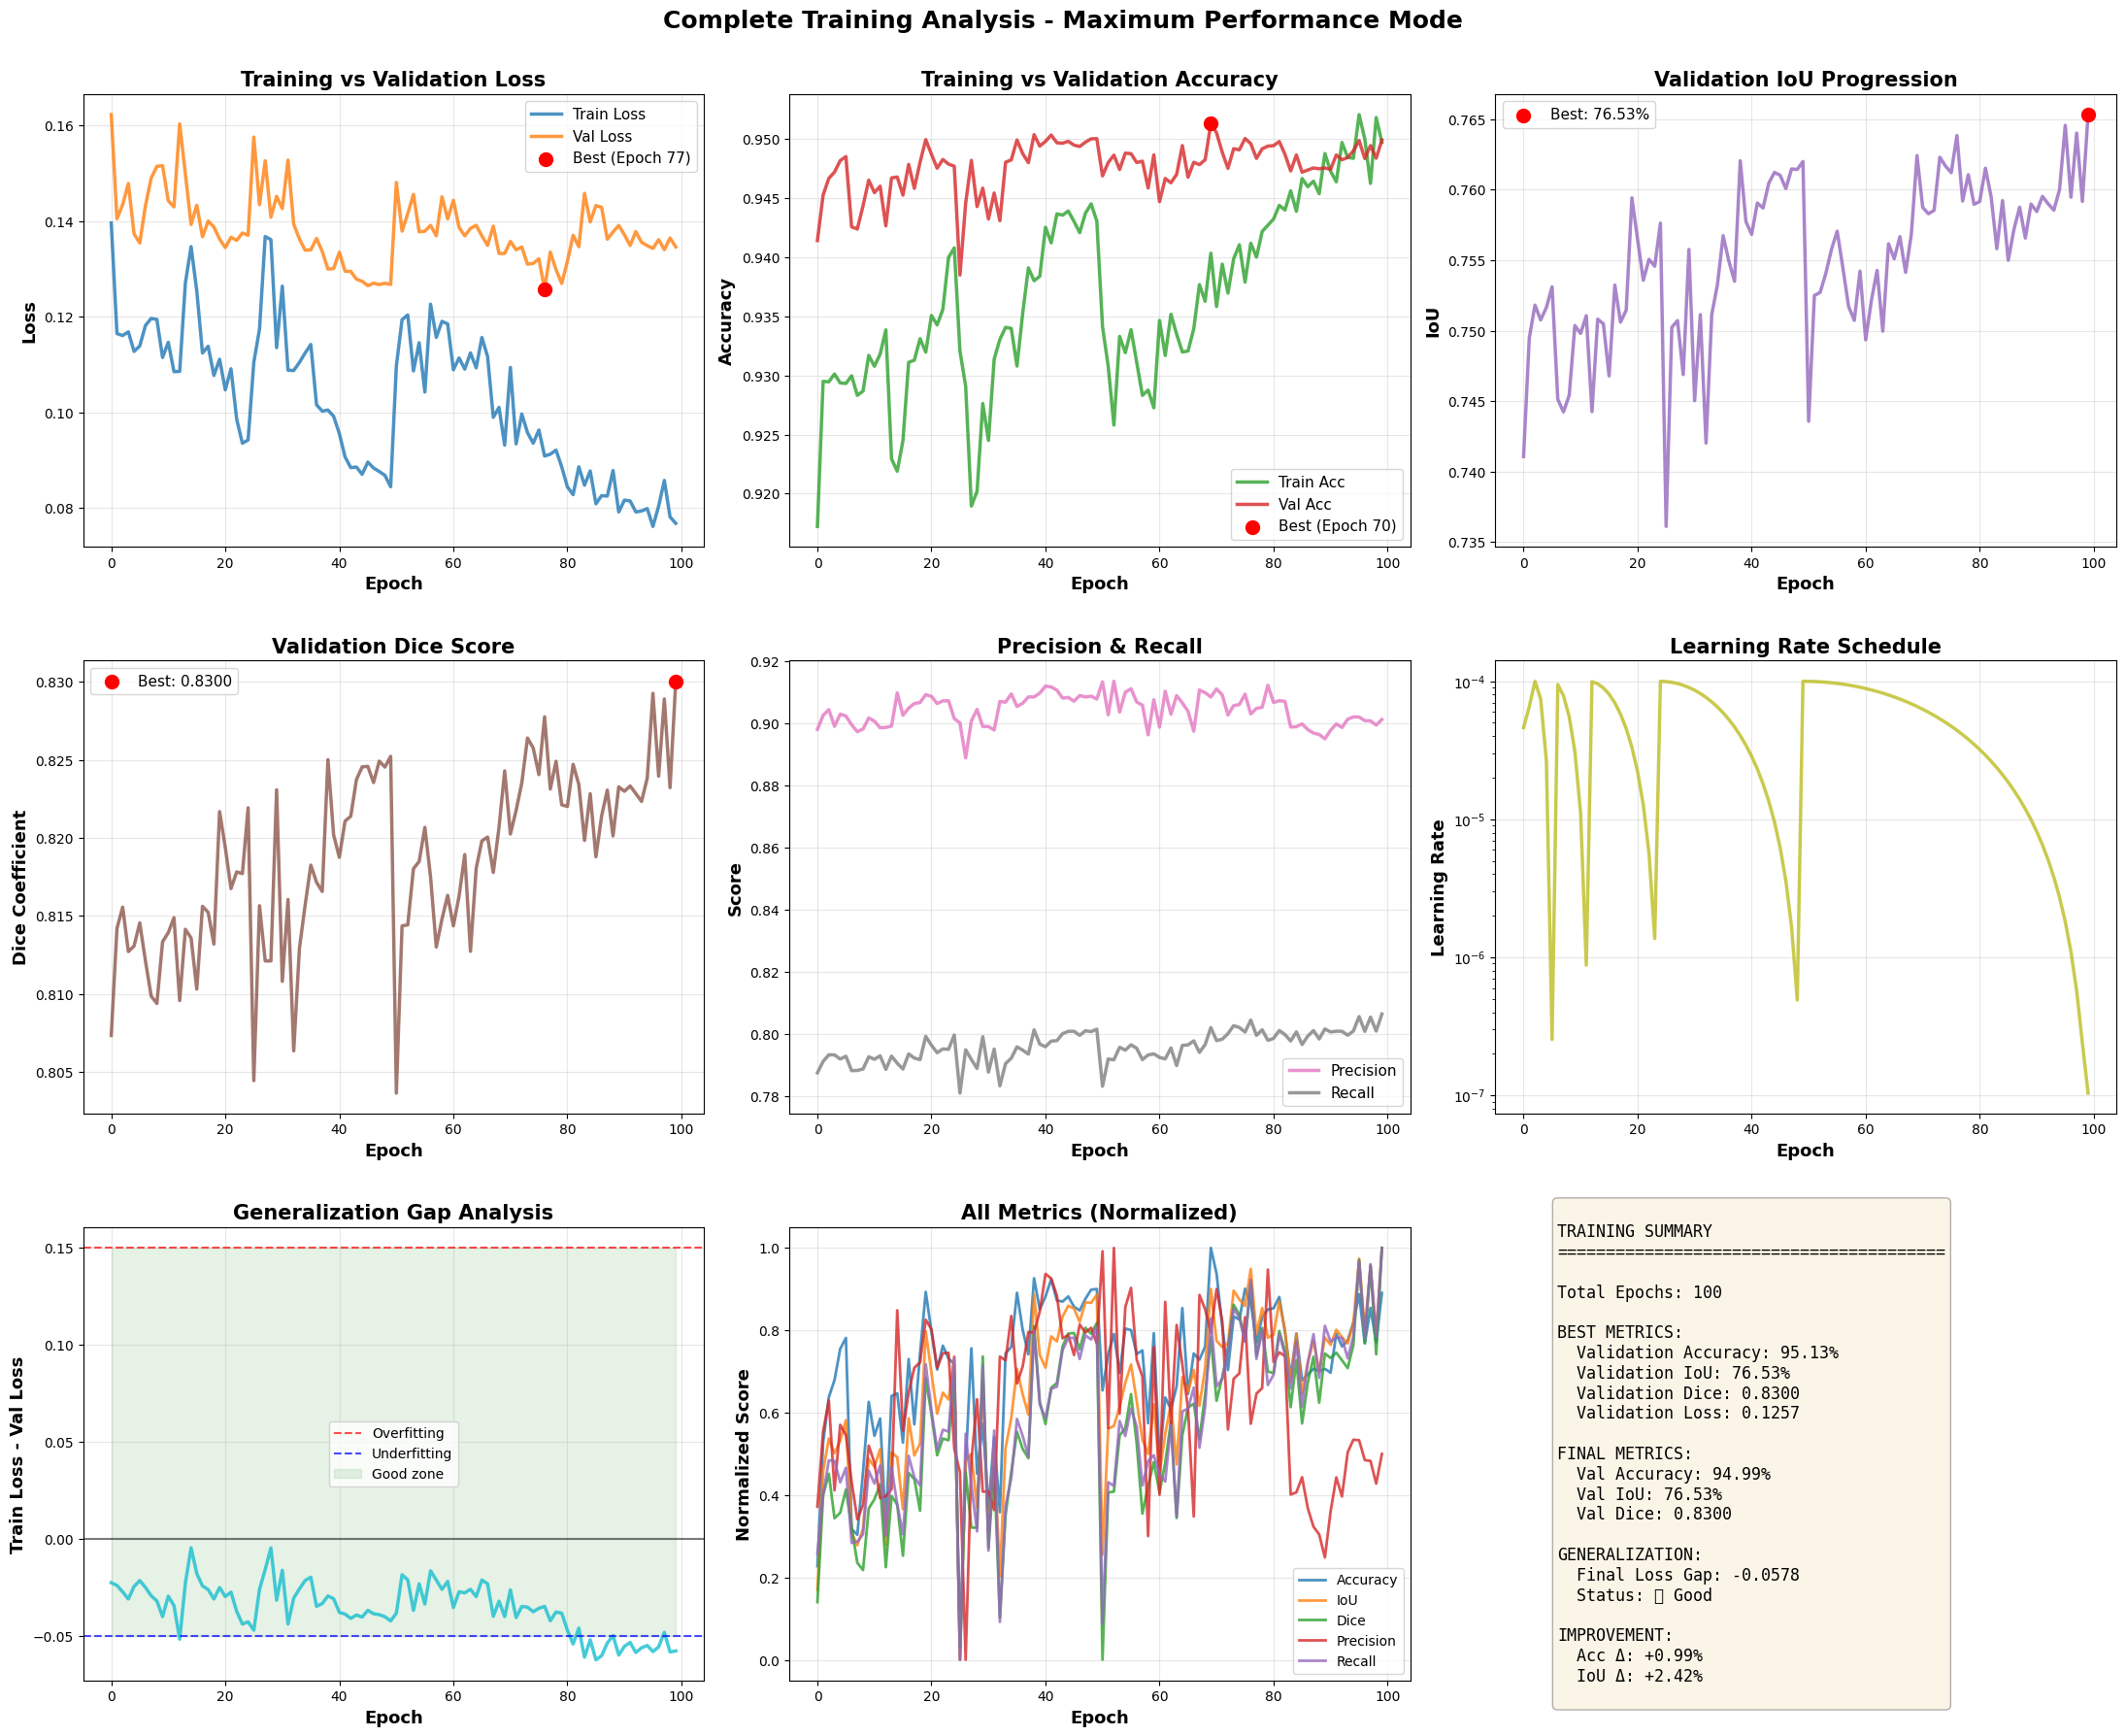


✅ Training analysis plots saved!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(22, 18))

# Plot 1: Loss curves
axes[0, 0].plot(history['train_loss'], linewidth=2.5, label='Train Loss', color='#1f77b4', alpha=0.8)
axes[0, 0].plot(history['val_loss'], linewidth=2.5, label='Val Loss', color='#ff7f0e', alpha=0.8)
best_loss_epoch = history['val_loss'].index(min(history['val_loss']))
axes[0, 0].scatter(best_loss_epoch, min(history['val_loss']),
                   color='red', s=100, zorder=5, label=f'Best (Epoch {best_loss_epoch+1})')
axes[0, 0].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[0, 0].set_ylabel('Loss', fontweight='bold', fontsize=13)
axes[0, 0].set_title('Training vs Validation Loss', fontweight='bold', fontsize=15)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0, 1].plot(history['train_acc'], linewidth=2.5, label='Train Acc', color='#2ca02c', alpha=0.8)
axes[0, 1].plot(history['val_acc'], linewidth=2.5, label='Val Acc', color='#d62728', alpha=0.8)
best_acc_epoch = history['val_acc'].index(max(history['val_acc']))
axes[0, 1].scatter(best_acc_epoch, max(history['val_acc']),
                   color='red', s=100, zorder=5, label=f'Best (Epoch {best_acc_epoch+1})')
axes[0, 1].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[0, 1].set_ylabel('Accuracy', fontweight='bold', fontsize=13)
axes[0, 1].set_title('Training vs Validation Accuracy', fontweight='bold', fontsize=15)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: IoU progression
axes[0, 2].plot(history['val_iou'], linewidth=2.5, color='#9467bd', alpha=0.8)
best_iou_epoch = history['val_iou'].index(max(history['val_iou']))
axes[0, 2].scatter(best_iou_epoch, max(history['val_iou']),
                   color='red', s=100, zorder=5, label=f'Best: {max(history["val_iou"])*100:.2f}%')
axes[0, 2].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[0, 2].set_ylabel('IoU', fontweight='bold', fontsize=13)
axes[0, 2].set_title('Validation IoU Progression', fontweight='bold', fontsize=15)
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Dice coefficient
axes[1, 0].plot(history['val_dice'], linewidth=2.5, color='#8c564b', alpha=0.8)
best_dice_epoch = history['val_dice'].index(max(history['val_dice']))
axes[1, 0].scatter(best_dice_epoch, max(history['val_dice']),
                   color='red', s=100, zorder=5, label=f'Best: {max(history["val_dice"]):.4f}')
axes[1, 0].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[1, 0].set_ylabel('Dice Coefficient', fontweight='bold', fontsize=13)
axes[1, 0].set_title('Validation Dice Score', fontweight='bold', fontsize=15)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Precision & Recall
axes[1, 1].plot(history['val_precision'], linewidth=2.5, label='Precision', color='#e377c2', alpha=0.8)
axes[1, 1].plot(history['val_recall'], linewidth=2.5, label='Recall', color='#7f7f7f', alpha=0.8)
axes[1, 1].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[1, 1].set_ylabel('Score', fontweight='bold', fontsize=13)
axes[1, 1].set_title('Precision & Recall', fontweight='bold', fontsize=15)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Learning rate schedule
axes[1, 2].plot(history['learning_rates'], linewidth=2.5, color='#bcbd22', alpha=0.8)
axes[1, 2].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[1, 2].set_ylabel('Learning Rate', fontweight='bold', fontsize=13)
axes[1, 2].set_title('Learning Rate Schedule', fontweight='bold', fontsize=15)
axes[1, 2].set_yscale('log')
axes[1, 2].grid(True, alpha=0.3)

# Plot 7: Loss gap (overfitting indicator)
loss_gap = np.array(history['train_loss']) - np.array(history['val_loss'])
axes[2, 0].plot(loss_gap, linewidth=2.5, color='#17becf', alpha=0.8)
axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
axes[2, 0].axhline(y=0.15, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Overfitting')
axes[2, 0].axhline(y=-0.05, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, label='Underfitting')
axes[2, 0].fill_between(range(len(loss_gap)), -0.05, 0.15, alpha=0.1, color='green', label='Good zone')
axes[2, 0].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[2, 0].set_ylabel('Train Loss - Val Loss', fontweight='bold', fontsize=13)
axes[2, 0].set_title('Generalization Gap Analysis', fontweight='bold', fontsize=15)
axes[2, 0].legend(fontsize=10)
axes[2, 0].grid(True, alpha=0.3)

# Plot 8: All metrics combined (normalized)
def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

axes[2, 1].plot(normalize(history['val_acc']), linewidth=2, label='Accuracy', alpha=0.8)
axes[2, 1].plot(normalize(history['val_iou']), linewidth=2, label='IoU', alpha=0.8)
axes[2, 1].plot(normalize(history['val_dice']), linewidth=2, label='Dice', alpha=0.8)
axes[2, 1].plot(normalize(history['val_precision']), linewidth=2, label='Precision', alpha=0.8)
axes[2, 1].plot(normalize(history['val_recall']), linewidth=2, label='Recall', alpha=0.8)
axes[2, 1].set_xlabel('Epoch', fontweight='bold', fontsize=13)
axes[2, 1].set_ylabel('Normalized Score', fontweight='bold', fontsize=13)
axes[2, 1].set_title('All Metrics (Normalized)', fontweight='bold', fontsize=15)
axes[2, 1].legend(fontsize=10)
axes[2, 1].grid(True, alpha=0.3)

# Plot 9: Summary statistics
axes[2, 2].axis('off')
summary_text = f"""
TRAINING SUMMARY
{'='*40}

Total Epochs: {len(history['train_loss'])}

BEST METRICS:
  Validation Accuracy: {max(history['val_acc'])*100:.2f}%
  Validation IoU: {max(history['val_iou'])*100:.2f}%
  Validation Dice: {max(history['val_dice']):.4f}
  Validation Loss: {min(history['val_loss']):.4f}

FINAL METRICS:
  Val Accuracy: {history['val_acc'][-1]*100:.2f}%
  Val IoU: {history['val_iou'][-1]*100:.2f}%
  Val Dice: {history['val_dice'][-1]:.4f}

GENERALIZATION:
  Final Loss Gap: {loss_gap[-1]:.4f}
  Status: {"✅ Good" if abs(loss_gap[-1]) < 0.10 else "⚠️ Check"}

IMPROVEMENT:
  Acc Δ: {(max(history['val_acc']) - history['val_acc'][0])*100:+.2f}%
  IoU Δ: {(max(history['val_iou']) - history['val_iou'][0])*100:+.2f}%
"""
axes[2, 2].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
               verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Complete Training Analysis - Maximum Performance Mode',
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('complete_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training analysis plots saved!")


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# ---- Class setup (must match your rgbToClass mapping in dataset) ----
# From your notebook:
# 0: [0,0,0]
# 1: [255,0,124]
# 2: [255,204,51]
# 3: [51,221,255]
CLASS_NAMES = ["Background", "Oil Spill", "Look-alike", "Ship/Wake"]  # rename if your labels differ
CLASS_COLORS = np.array([
    [0,   0,   0  ],   # 0
    [255, 0,   124],   # 1
    [255, 204, 51 ],   # 2
    [51,  221, 255],   # 3
], dtype=np.uint8)

def decode_mask_to_rgb(mask_2d: np.ndarray, class_colors: np.ndarray = CLASS_COLORS) -> np.ndarray:
    """
    mask_2d: (H,W) int {0..C-1}
    returns: (H,W,3) uint8 RGB
    """
    mask_2d = mask_2d.astype(np.int32)
    return class_colors[mask_2d]

def overlay_mask_on_image(
    image_rgb: np.ndarray,
    mask_2d: np.ndarray,
    alpha: float = 0.45,
    class_colors: np.ndarray = CLASS_COLORS,
    draw_contours: bool = True,
    contour_color=(255, 255, 255),
    contour_thickness: int = 1
) -> np.ndarray:
    """
    image_rgb: (H,W,3) uint8 or float in [0,1]
    mask_2d: (H,W) int
    """
    if image_rgb.dtype != np.uint8:
        img_u8 = np.clip(image_rgb * 255.0, 0, 255).astype(np.uint8)
    else:
        img_u8 = image_rgb.copy()

    mask_rgb = decode_mask_to_rgb(mask_2d, class_colors)

    # Blend only where mask != 0 (ignore background)
    out = img_u8.copy()
    fg = (mask_2d != 0)
    out[fg] = (alpha * mask_rgb[fg] + (1 - alpha) * out[fg]).astype(np.uint8)

    if draw_contours:
        # draw contours around each non-background class for clarity
        for cls_id in range(1, class_colors.shape[0]):
            bin_mask = (mask_2d == cls_id).astype(np.uint8) * 255
            if bin_mask.sum() == 0:
                continue
            contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(out, contours, -1, contour_color, contour_thickness)

    return out

@torch.inference_mode()
def predict_mask(model, image_tensor: torch.Tensor, device: torch.device) -> np.ndarray:
    """
    image_tensor: (3,H,W) float tensor in [0,1]
    returns: (H,W) uint8 predicted class indices
    """
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)  # (1,3,H,W)
    logits = model(x)                         # (1,C,H,W)
    pred = torch.argmax(logits, dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)
    return pred

def tensor_to_rgb_image(img_tensor: torch.Tensor) -> np.ndarray:
    """
    img_tensor: (3,H,W) float in [0,1]
    returns: (H,W,3) float in [0,1]
    """
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0.0, 1.0)
    return img


In [ ]:
def show_samples_grid(
    model,
    dataset,
    device,
    n: int = 6,
    seed: int = 42,
    alpha: float = 0.45,
    save_path: str = None
):
    """
    Generates a grid with:
      Row per sample, Columns:
        1) Original
        2) Ground Truth mask (RGB)
        3) Predicted mask (RGB)
        4) GT overlay
        5) Pred overlay
    """
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(dataset), size=min(n, len(dataset)), replace=False)

    fig, axes = plt.subplots(len(indices), 5, figsize=(22, 4*len(indices)))
    if len(indices) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, idx in enumerate(indices):
        img_t, gt_t = dataset[idx]             # img: (3,H,W), gt: (H,W)
        img = tensor_to_rgb_image(img_t)       # float [0,1]
        gt = gt_t.detach().cpu().numpy().astype(np.uint8)
        pred = predict_mask(model, img_t, device)

        gt_rgb = decode_mask_to_rgb(gt)
        pred_rgb = decode_mask_to_rgb(pred)

        gt_overlay = overlay_mask_on_image(img, gt, alpha=alpha)
        pred_overlay = overlay_mask_on_image(img, pred, alpha=alpha)

        # Plot
        axes[r,0].imshow(img)
        axes[r,0].set_title(f"Original (idx={idx})")
        axes[r,1].imshow(gt_rgb)
        axes[r,1].set_title("Ground Truth")
        axes[r,2].imshow(pred_rgb)
        axes[r,2].set_title("Prediction")
        axes[r,3].imshow(gt_overlay)
        axes[r,3].set_title("GT Overlay")
        axes[r,4].imshow(pred_overlay)
        axes[r,4].set_title("Pred Overlay")

        for c in range(5):
            axes[r,c].axis("off")

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True) if os.path.dirname(save_path) else None
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()


In [ ]:
import torch
import segmentation_models_pytorch as smp

def getmodelencoderresnet34(encoder="resnet34", numclasses=4):
    model = smp.Unet(
        encoder_name=encoder,
        encoder_weights="imagenet",
        in_channels=3,
        classes=numclasses,
        activation=None
    )
    return model


In [ ]:
import os, torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_PATH = "/content/best_model.pth"

assert os.path.exists(CKPT_PATH), "Checkpoint not found."

model = getmodelencoderresnet34(encoder="resnet34", numclasses=4).to(DEVICE)

# Add weights_only=False to allow numpy objects
ckpt = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=False)

if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    model.load_state_dict(ckpt["model_state_dict"])
    print("Loaded from checkpoint dict. Epoch:", ckpt.get("epoch", "?"), "Val IoU:", ckpt.get("val_iou", "?"))
else:
    model.load_state_dict(ckpt)
    print("Loaded raw state_dict.")

model.eval()
print("Model ready for inference!")


Loaded from checkpoint dict. Epoch: 99 Val IoU: 0.7653162752355676
Model ready for inference!


In [ ]:
import os
from torch.utils.data import Dataset
import cv2
import numpy as np
import torch

# Your OilSpillDataset class (paste from your notebook)
class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.size = size

        # Get paired files
        img_files = set(os.listdir(img_dir))
        mask_files = set(os.listdir(mask_dir))
        img_stems = {os.path.splitext(f)[0] for f in img_files}
        mask_stems = {os.path.splitext(f)[0] for f in mask_files}
        paired_stems = img_stems.intersection(mask_stems)

        self.pairs = []
        for stem in paired_stems:
            img_file = [f for f in img_files if os.path.splitext(f)[0]==stem][0]
            mask_file = [f for f in mask_files if os.path.splitext(f)[0]==stem][0]
            self.pairs.append((img_file, mask_file))

        print(f"Loaded {len(self.pairs)} pairs from {img_dir}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]

        # Load image
        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(os.path.join(self.mask_dir, mask_name))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Resize
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # Convert mask to class indices
        mask = self.rgb_to_class(mask)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Normalize image
        img = img.astype(np.float32) / 255.0

        # Convert to tensor
        img = torch.from_numpy(img.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).long()

        return img, mask

    def rgb_to_class(self, mask):
        """Convert RGB to class indices with tolerance"""
        h, w = mask.shape[:2]
        class_mask = np.zeros((h, w), dtype=np.uint8)

        colors = {
            0: np.array([0, 0, 0]),
            1: np.array([255, 0, 124]),
            2: np.array([255, 204, 51]),
            3: np.array([51, 221, 255]),
        }

        for class_id, color in colors.items():
            diff = np.abs(mask.astype(np.float32) - color.astype(np.float32))
            matches = np.all(diff < 30, axis=-1)
            class_mask[matches] = class_id

        return class_mask

# Create datasets
IMG_SIZE = 256

valdataset = OilSpillDataset("val/images", "val/masks", transform=None, size=IMG_SIZE)
testdataset = OilSpillDataset("test/images", "test/masks", transform=None, size=IMG_SIZE)

print("Datasets ready!")


Loaded 203 pairs from val/images
Loaded 254 pairs from test/images
Datasets ready!


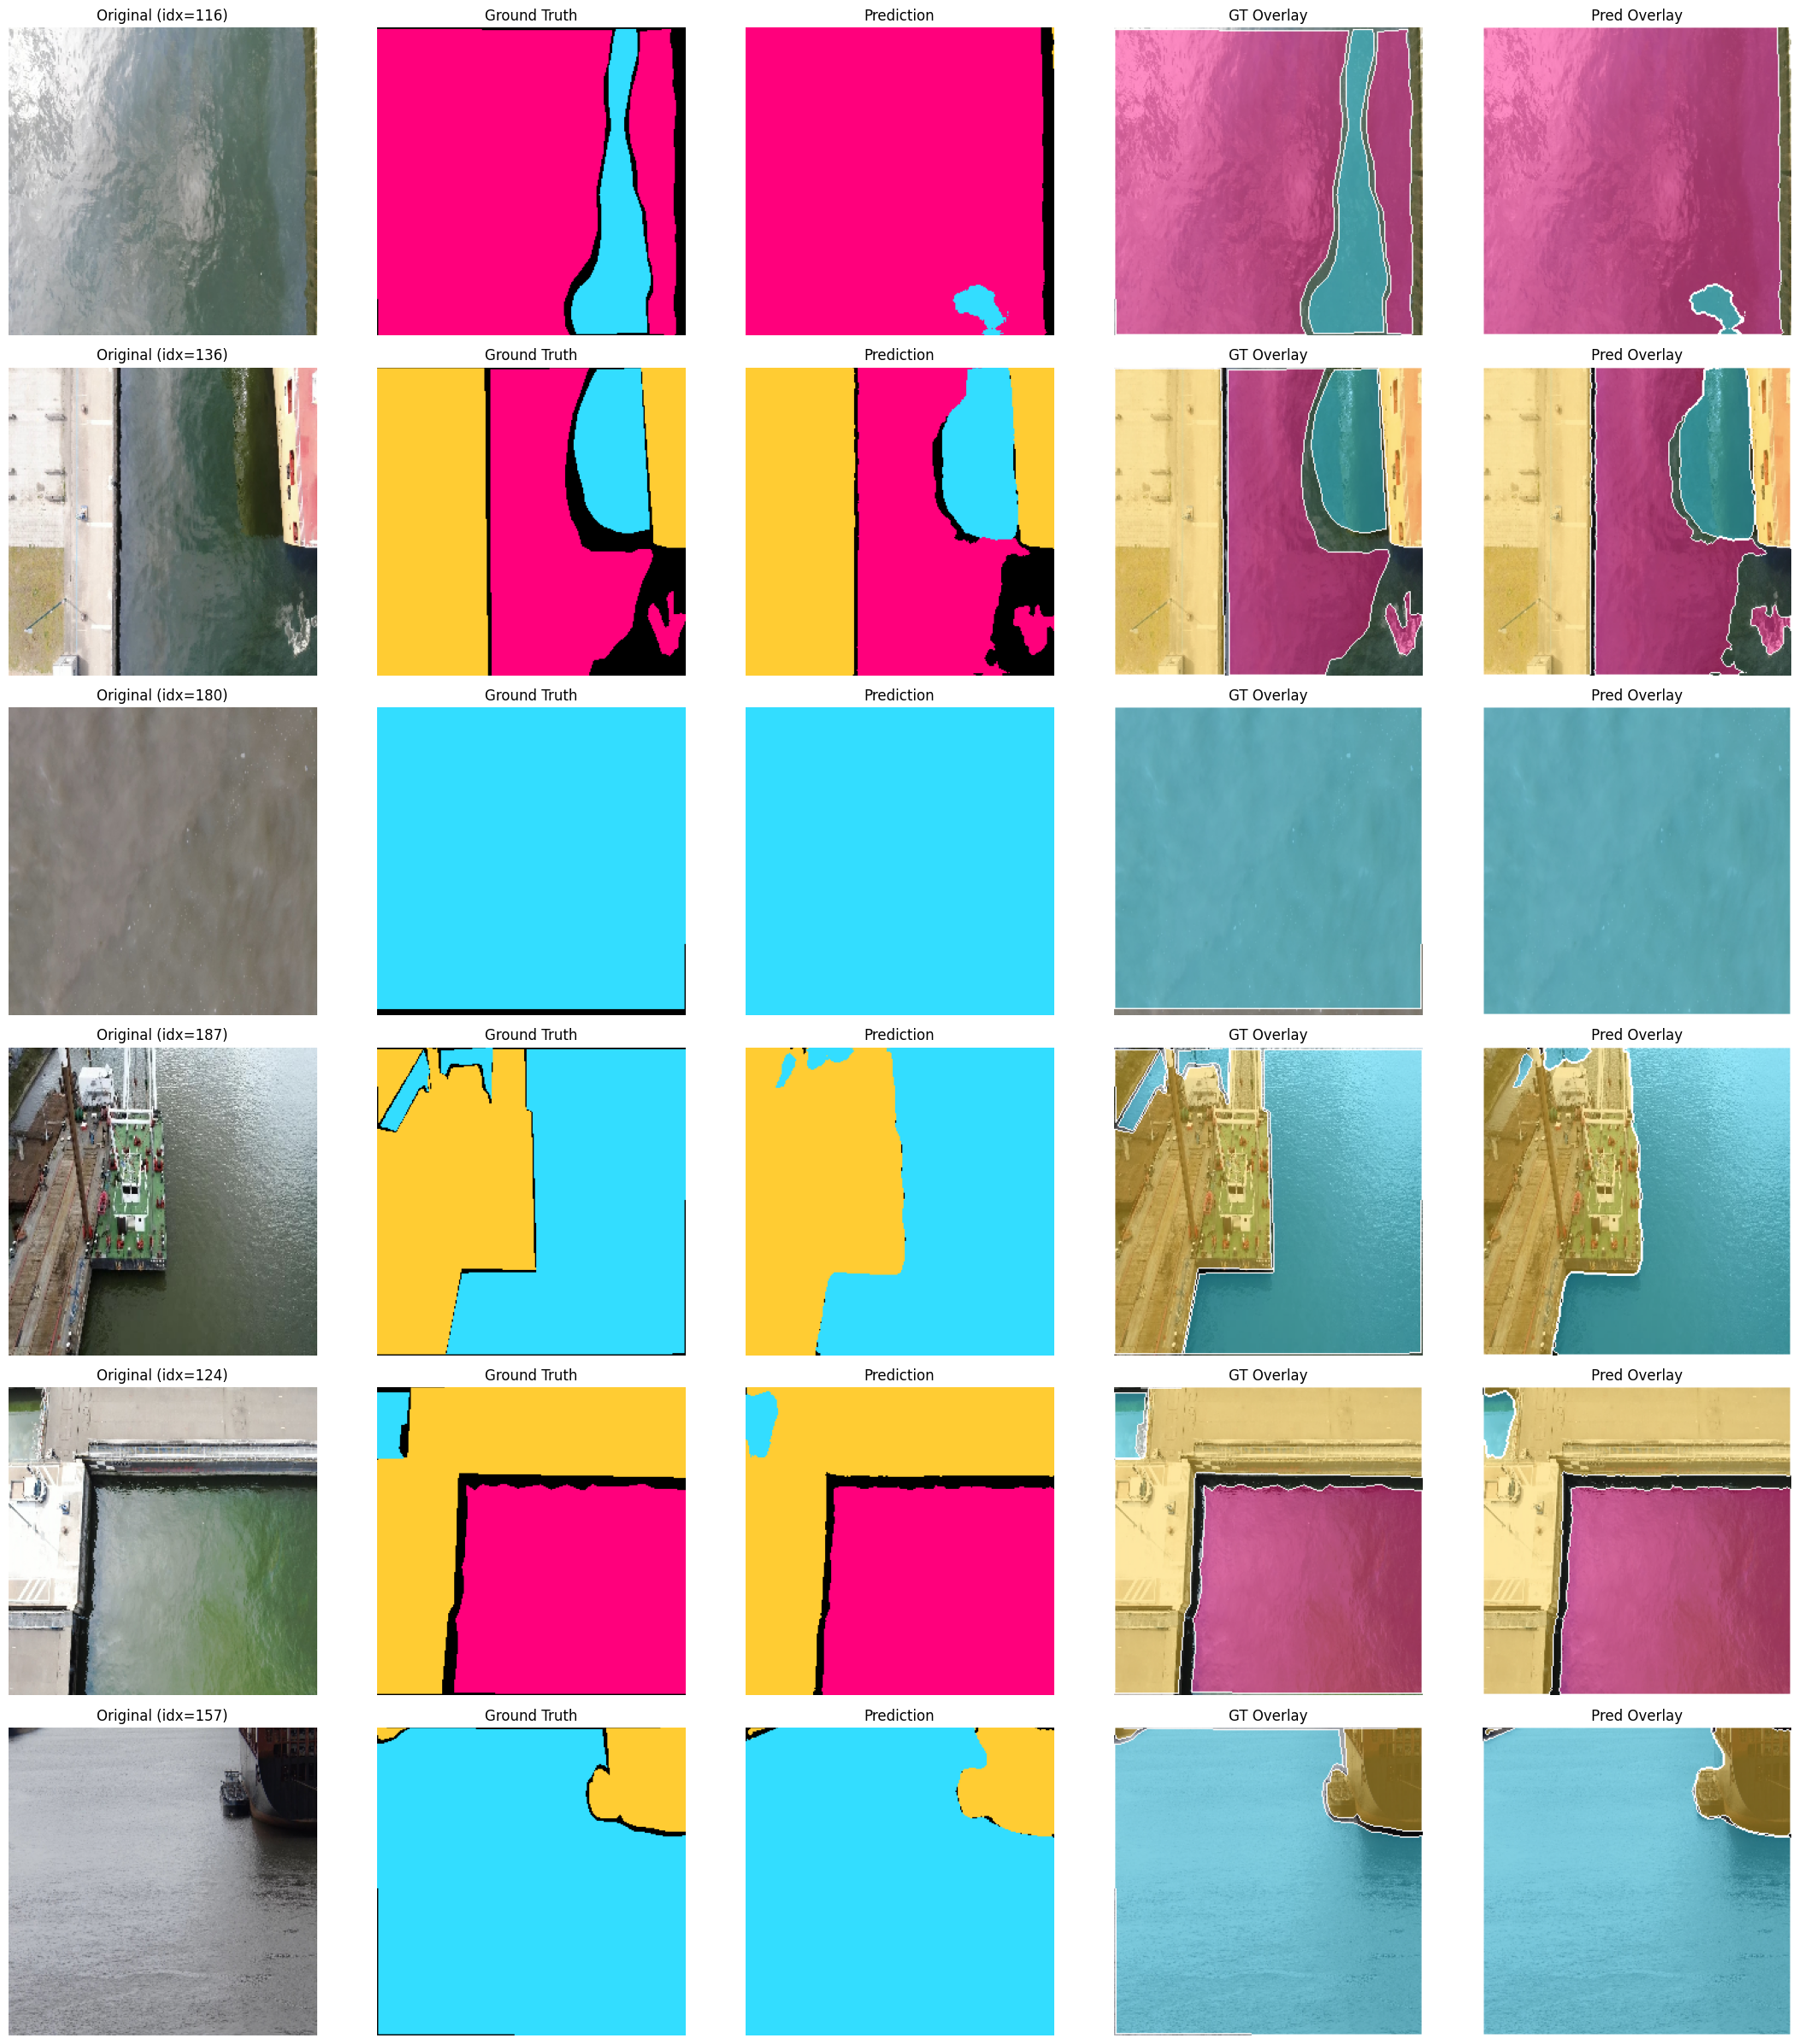

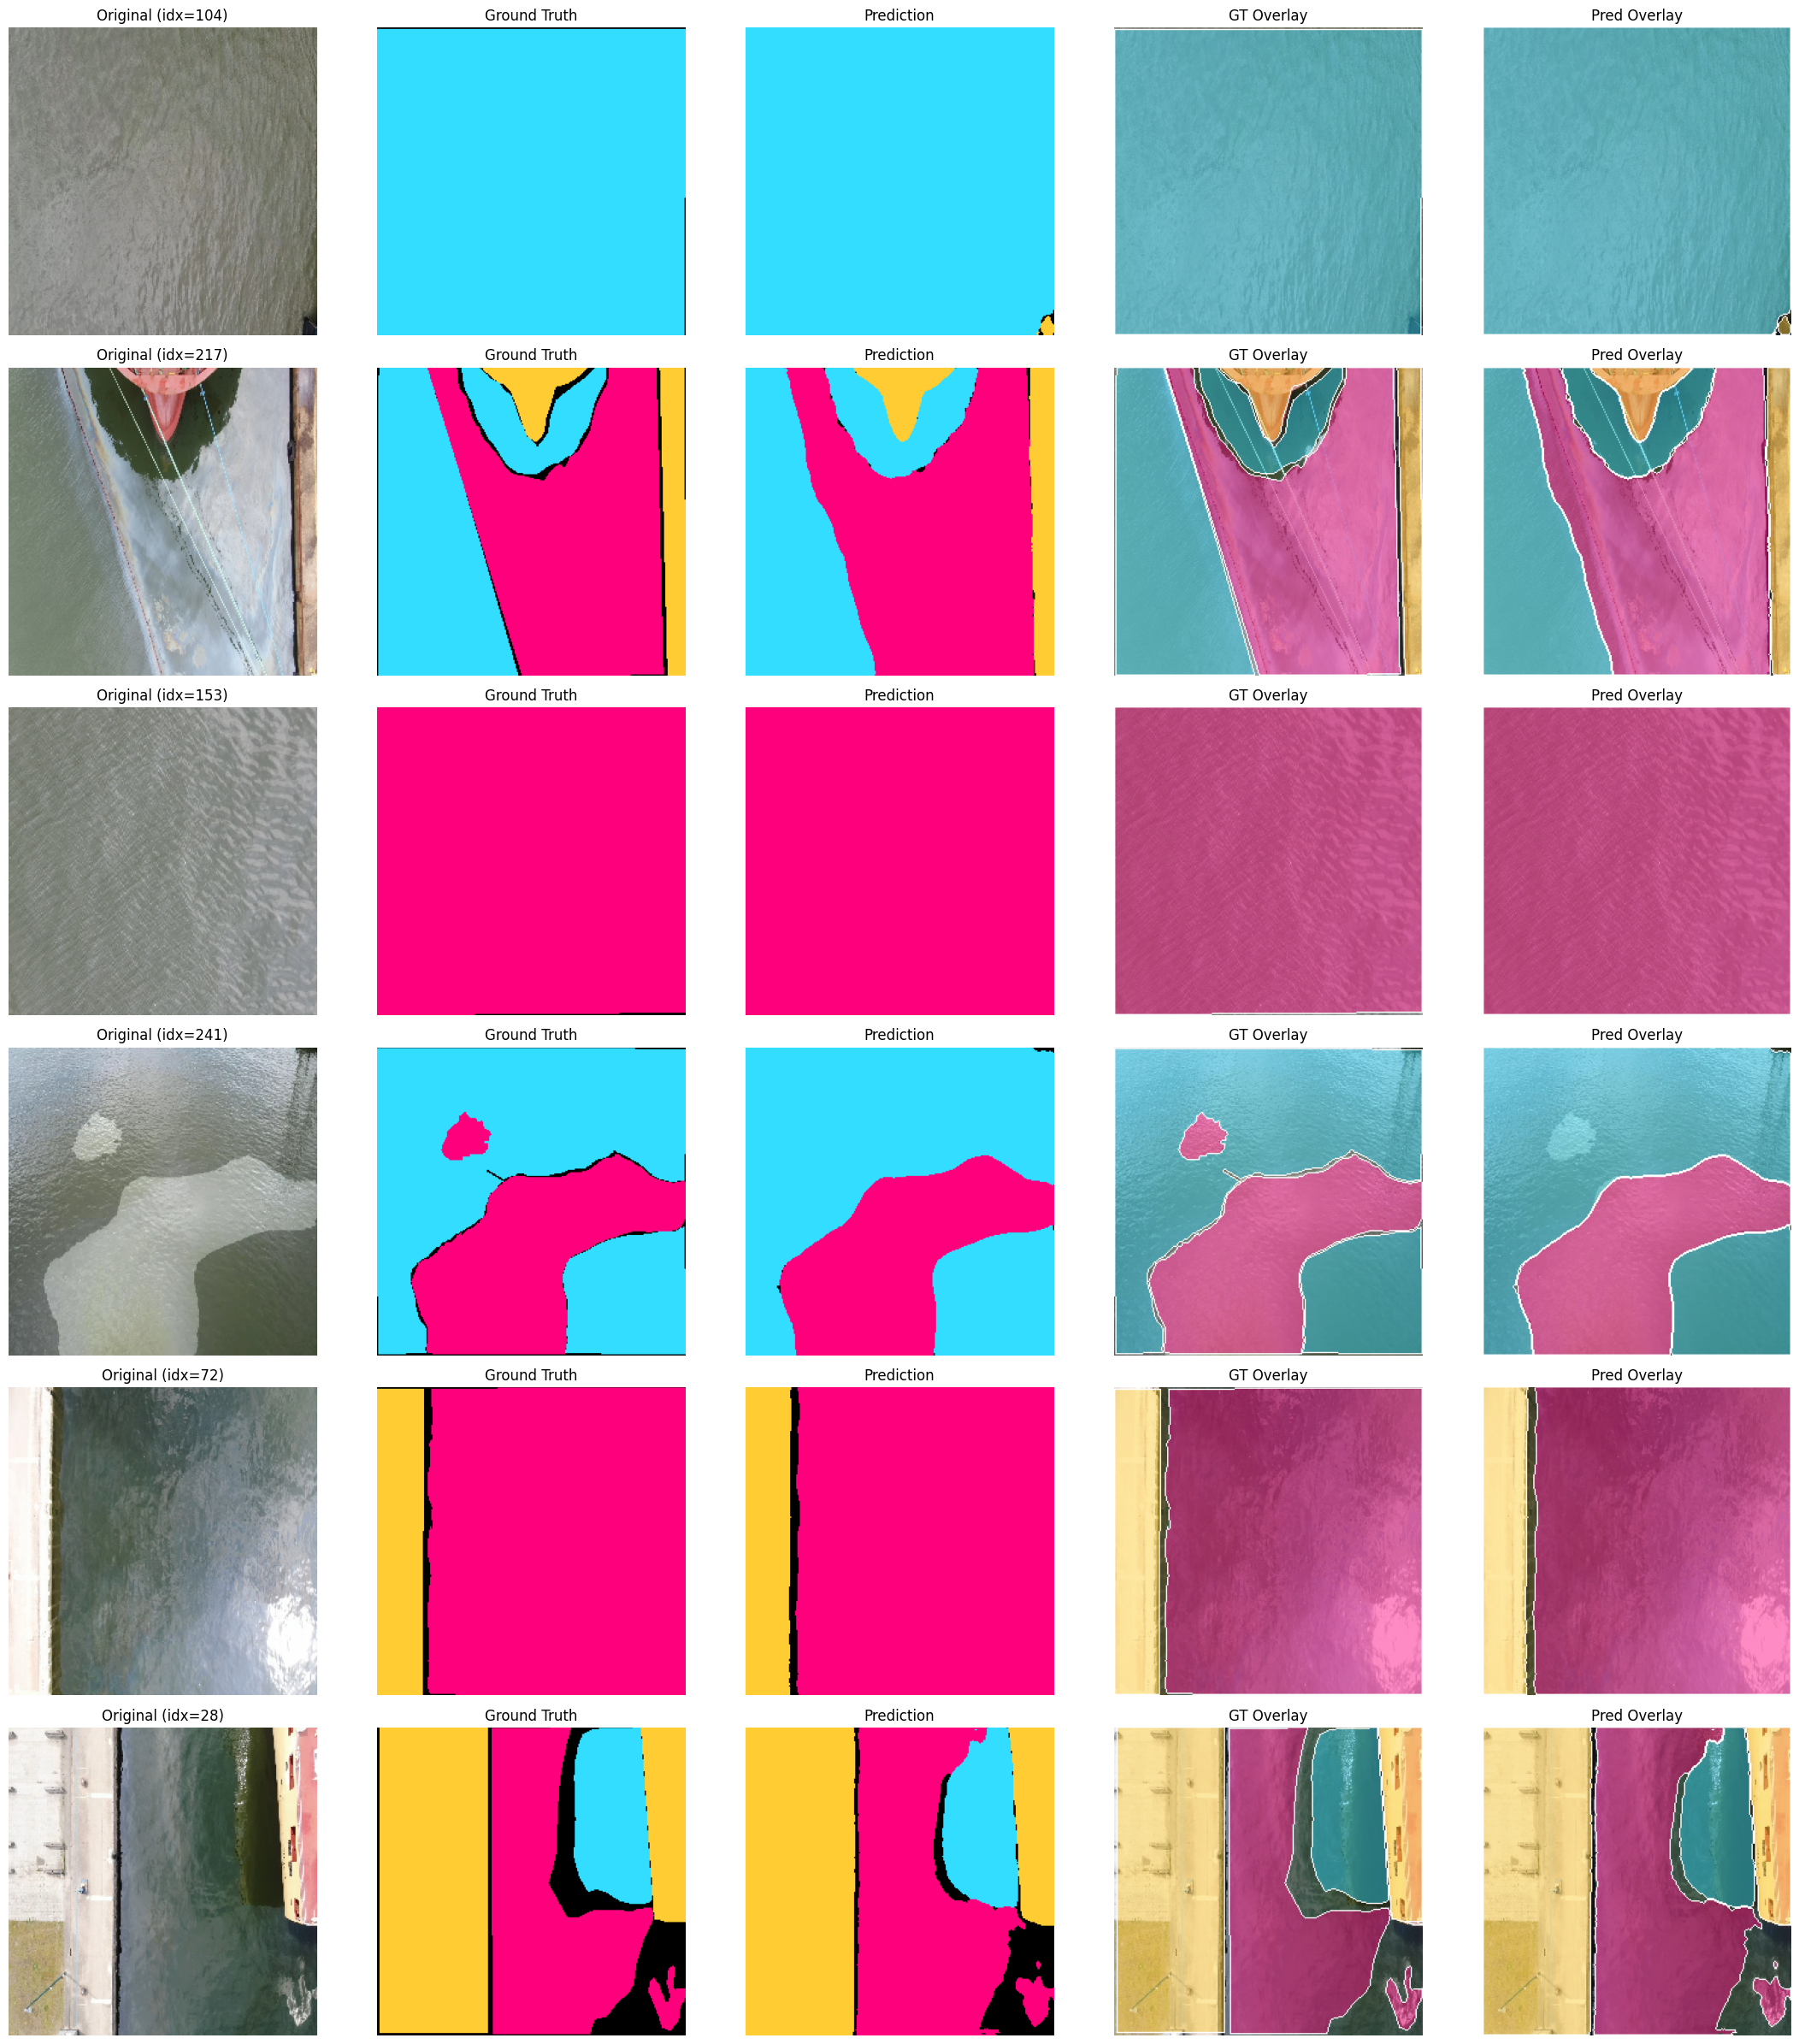

In [ ]:
# Validation examples
show_samples_grid(
    model=model,
    dataset=valdataset,
    device=DEVICE,
    n=6,
    seed=7,
    alpha=0.45,
    save_path="outputs/val_visual_grid.png"
)

# Test examples
show_samples_grid(
    model=model,
    dataset=testdataset,
    device=DEVICE,
    n=6,
    seed=9,
    alpha=0.45,
    save_path="outputs/test_visual_grid.png"
)


In [ ]:
@torch.inference_mode()
def infer_on_rgb_image(model, rgb_image: np.ndarray, device, img_size: int = 256, alpha: float = 0.45):
    # Ensure RGB uint8
    if rgb_image.dtype != np.uint8:
        rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

    # Resize to model input
    img_resized = cv2.resize(rgb_image, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

    # To tensor [0,1]
    x = (img_resized.astype(np.float32) / 255.0)
    x = torch.from_numpy(x).permute(2,0,1).float().unsqueeze(0).to(device)

    logits = model(x)
    pred = torch.argmax(logits, dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)

    overlay = overlay_mask_on_image(img_resized, pred, alpha=alpha)
    pred_rgb = decode_mask_to_rgb(pred)

    return pred, pred_rgb, overlay


In [ ]:
from google.colab import files
files.download('/content/best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>